#### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification on imbalanced data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/imbalanced_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/imbalanced_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Select a threshold for a probabilistic classifier to get a deterministic classifier.
* Try and compare with class weighted modelling and oversampling.

## Setup

In [3]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [5]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [8]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [9]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class')).reshape(-1, 1)
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('Class')).reshape(-1, 1)
test_labels = np.array(test_df.pop('Class')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

We check whether the distribution of the classes in the three sets is about the same or not.

In [10]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0017
Average class probability in validation set: 0.0018
Average class probability in test set:       0.0018


Given the small number of positive labels, this seems about right.

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets.

In [11]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276, 1)
Validation labels shape: (45569, 1)
Test labels shape: (56962, 1)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense?
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

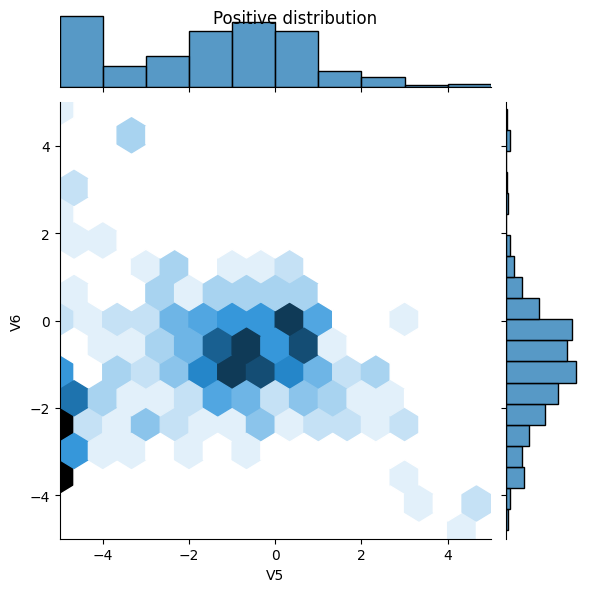

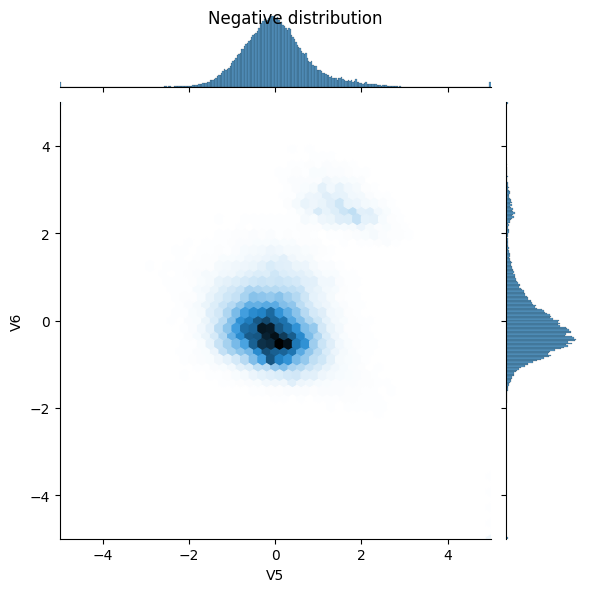

In [12]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

In [13]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.
These can be divided into three groups.

#### Metrics for probability predictions

As we train our network with the cross entropy as a loss function, it is fully capable of predicting class probabilities, i.e., it is a probabilistic classifier.
Good metrics to assess probabilistic predictions are, in fact, **proper scoring rules**. Their key property is that predicting the true probability is optimal. We give two well-known examples:

*   **cross entropy** also known as log loss
*   **Mean squared error** also known as the Brier score

#### Metrics for deterministic 0/1 predictions

In the end, one often wants to predict a class label, 0 or 1, *no fraud* or *fraud*.
This is called a deterministic classifier.
To get a label prediction from our probabilistic classifier, one needs to choose a probability threshold $t$.
The default is to predict label 1 (fraud) if the predicted probability is larger than $t=50\%$ and all the following metrics implicitly use this default.

*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$

**Note:** Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

#### Other metrices

The following metrics take into account all possible choices of thresholds $t$.

*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.


#### Read more:
*   [Strictly Proper Scoring Rules, Prediction, and Estimation](https://www.stat.washington.edu/people/raftery/Research/PDF/Gneiting2007jasa.pdf)
*   [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*   [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: Fitting this model will not handle the class imbalance efficiently. You will improve it later in this tutorial.

In [14]:
EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [15]:
model = make_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Test run the model:

In [16]:
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


array([[0.92941   ],
       [0.7950719 ],
       [0.76666075],
       [0.8932131 ],
       [0.9403445 ],
       [0.6492615 ],
       [0.86598873],
       [0.90923446],
       [0.95876485],
       [0.74320334]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314`

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.8726


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [18]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses.

It should be near: `pos/total = 0.0018`

In [19]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([[1.4279470e-04],
       [1.8295081e-03],
       [8.8667381e-04],
       [6.2185130e-04],
       [9.3956660e-05],
       [3.2803013e-03],
       [6.6571642e-04],
       [4.3339375e-04],
       [3.4436796e-04],
       [6.5301446e-04]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [20]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0149


This initial loss is about 50 times less than it would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. It also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [21]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [22]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [23]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [24]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

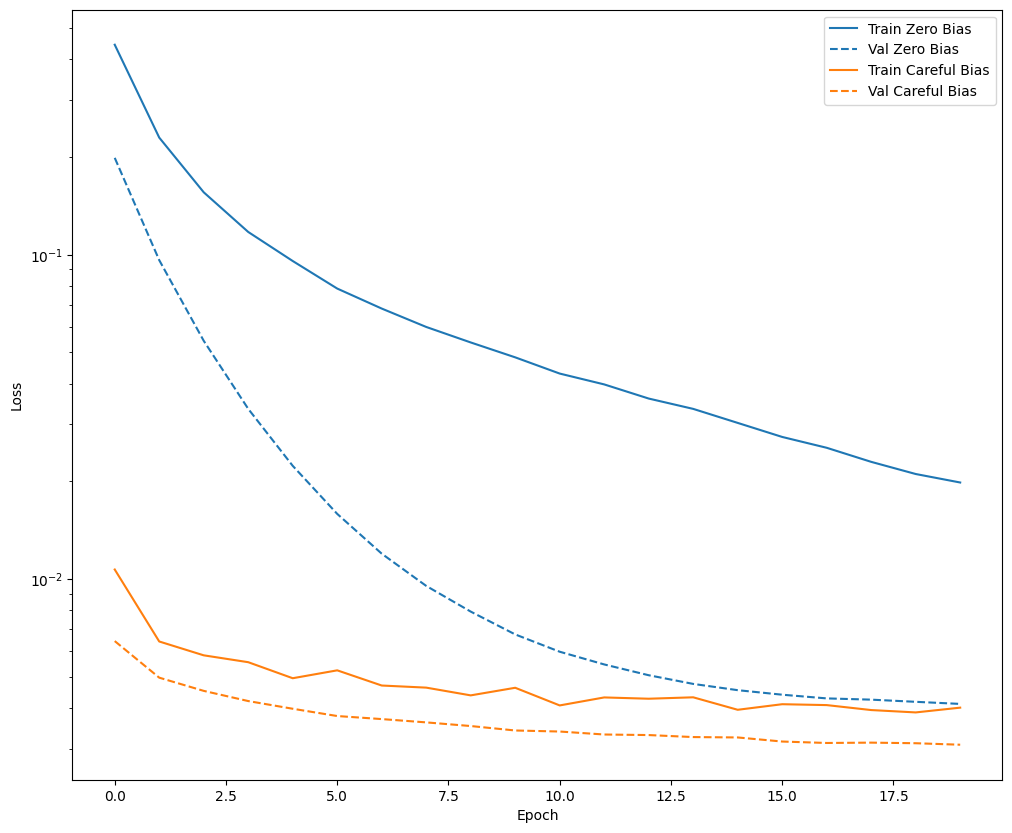

In [25]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage.

### Train the model

In [26]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - Brier score: 0.0012 - accuracy: 0.9987 - auc: 0.7736 - cross entropy: 0.0091 - fn: 172.6374 - fp: 14.9890 - loss: 0.0131 - prc: 0.3810 - precision: 0.8240 - recall: 0.3294 - tn: 139452.2812 - tp: 69.6593 - val_Brier score: 0.0012 - val_accuracy: 0.9986 - val_auc: 0.8926 - val_cross entropy: 0.0065 - val_fn: 57.0000 - val_fp: 6.0000 - val_loss: 0.0065 - val_prc: 0.6244 - val_precision: 0.7931 - val_recall: 0.2875 - val_tn: 45483.0000 - val_tp: 23.0000
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - Brier score: 0.0011 - accuracy: 0.9988 - auc: 0.8495 - cross entropy: 0.0072 - fn: 96.7473 - fp: 12.4725 - loss: 0.0072 - prc: 0.4625 - precision: 0.8183 - recall: 0.3438 - tn: 93977.0312 - tp: 54.3187 - val_Brier score: 8.5536e-04 - val_accuracy: 0.9990 - val_auc: 0.8997 - val_cross entropy: 0.0050 - val_fn: 36.0000 - val_fp: 9.0000 - val_loss: 0.0050 - val_prc: 0.6782 - val_precision: 0.8302 - val_recall: 0.5500 - val_tn: 45480.0000

### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [27]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

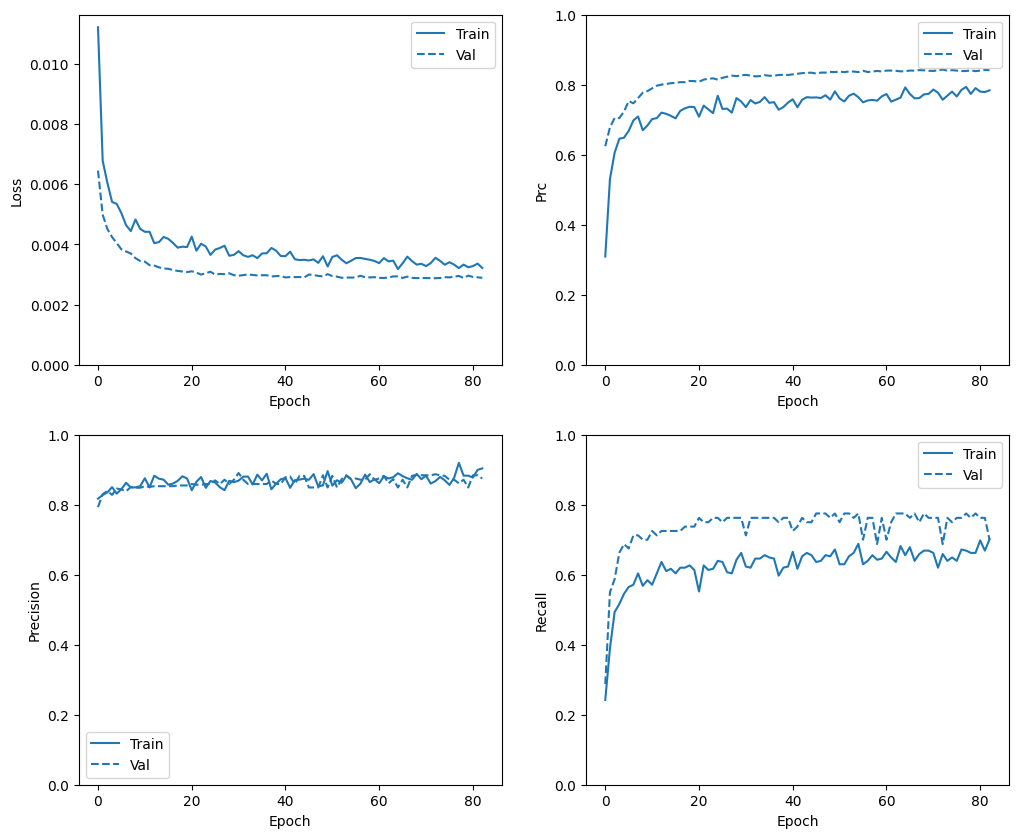

In [28]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [29]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [30]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.0031400080770254135
compile_metrics :  0.0031400080770254135

Legitimate Transactions Detected (True Negatives):  56852
Legitimate Transactions Incorrectly Detected (False Positives):  6
Fraudulent Transactions Missed (False Negatives):  26
Fraudulent Transactions Detected (True Positives):  78
Total Fraudulent Transactions:  104


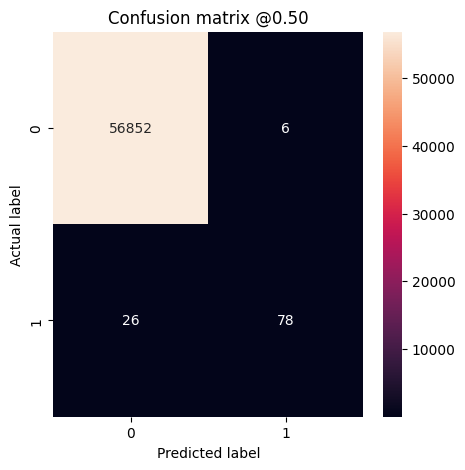

In [31]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly (impossible with true randomness), this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case, the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged.

### Changing the threshold

The default threshold of $t=50\%$ corresponds to equal costs of false negatives and false positives.
In the case of fraud detection, however, you would likely associate higher costs to false negatives than to false positives.
This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

By decreasing the threshold, we attribute higher cost to false negatives, thereby increasing missed transactions at the price of more false positives.
We test thresholds at 10% and at 1%.

Legitimate Transactions Detected (True Negatives):  56838
Legitimate Transactions Incorrectly Detected (False Positives):  20
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  81
Total Fraudulent Transactions:  104
Legitimate Transactions Detected (True Negatives):  56792
Legitimate Transactions Incorrectly Detected (False Positives):  66
Fraudulent Transactions Missed (False Negatives):  17
Fraudulent Transactions Detected (True Positives):  87
Total Fraudulent Transactions:  104


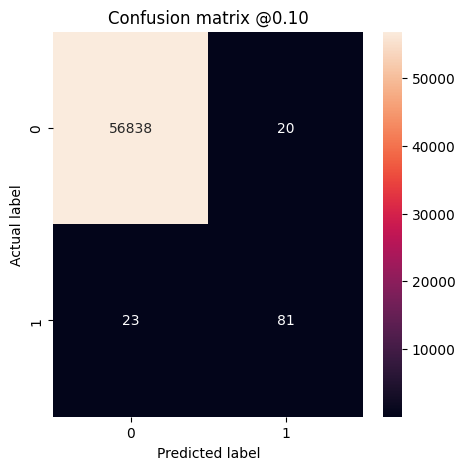

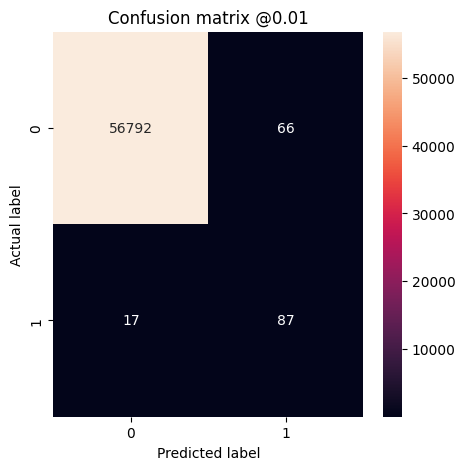

In [32]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach by tuning the output threshold over its full range (0 to 1). So each point corresponds to a single value of the threshold.

In [33]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

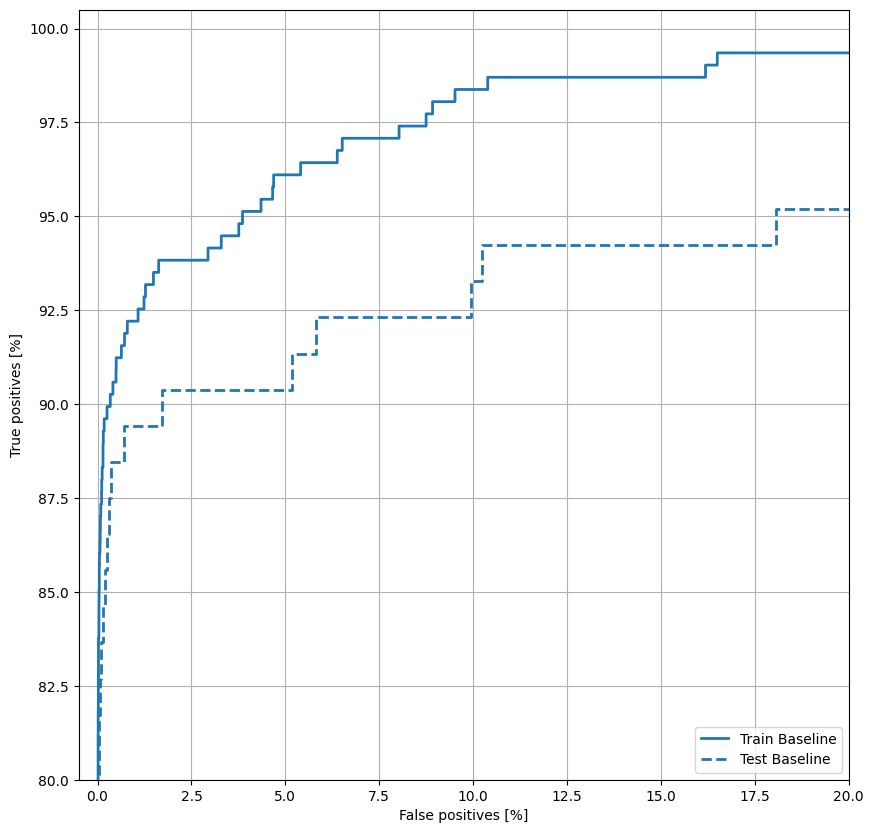

In [34]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the PRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [35]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

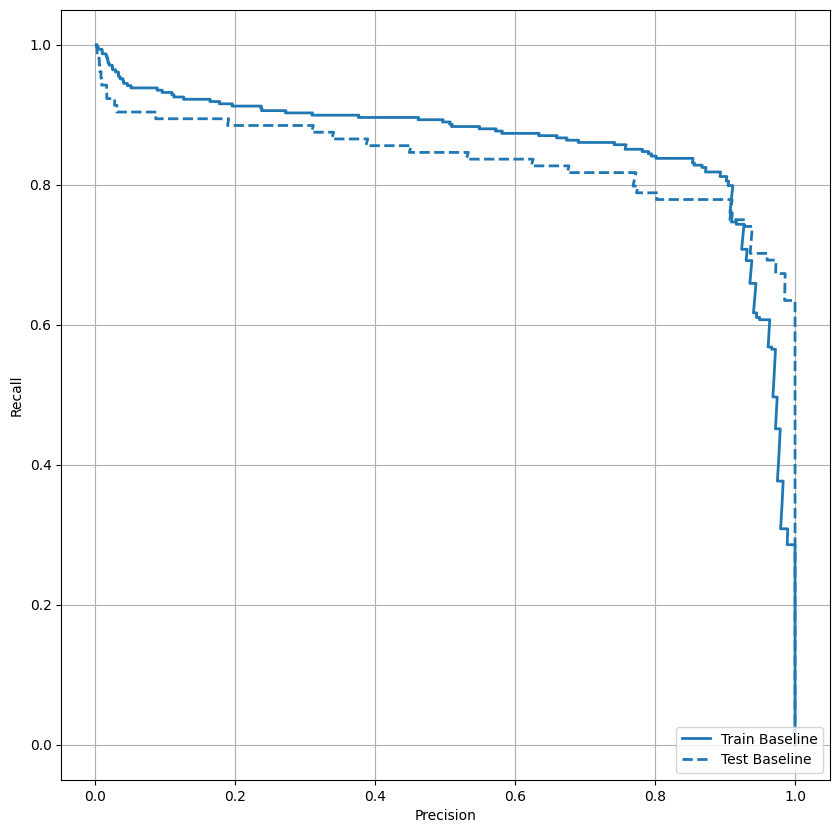

In [36]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class. Note, however, that this does not increase in any way the amount of information of your dataset. In the end, using class weights is more or less equivalent to changing the output bias or to changing the threshold. Let's see how it works out.

In [37]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [38]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Brier score: 0.0012 - accuracy: 0.9988 - auc: 0.7869 - cross entropy: 0.0093 - fn: 172.7582 - fp: 24.2088 - loss: 3.1959 - prc: 0.4219 - precision: 0.8160 - recall: 0.3846 - tn: 150812.7500 - tp: 92.8571 - val_Brier score: 0.0010 - val_accuracy: 0.9988 - val_auc: 0.9056 - val_cross entropy: 0.0069 - val_fn: 47.0000 - val_fp: 7.0000 - val_loss: 0.0069 - val_prc: 0.5834 - val_precision: 0.8250 - val_recall: 0.4125 - val_tn: 45482.0000 - val_tp: 33.0000
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Brier score: 0.0017 - accuracy: 0.9982 - auc: 0.8666 - cross entropy: 0.0118 - fn: 80.9231 - fp: 90.7253 - loss: 1.0835 - prc: 0.3989 - precision: 0.4638 - recall: 0.4481 - tn: 93893.1875 - tp: 75.7363 - val_Brier score: 7.7680e-04 - val_accuracy: 0.9992 - val_auc: 0.9380 - val_cross entropy: 0.0081 - val_fn: 23.0000 - val_fp: 13.0000 - val_loss: 0.0081 - val_prc: 0.6578 - val_precision: 0.8143 - val_recall: 0.7125 - val_tn: 45476.000

### Check training history

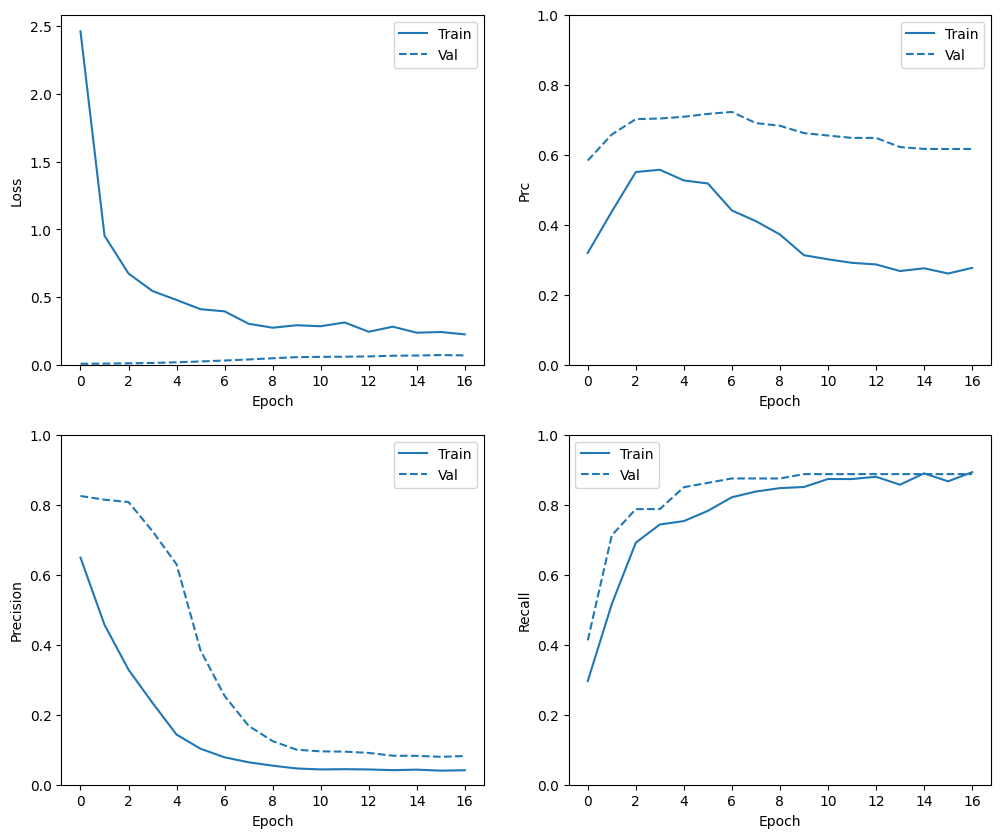

In [39]:
plot_metrics(weighted_history)

### Evaluate metrics

In [40]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


loss :  0.03186320140957832
compile_metrics :  0.03186320140957832

Legitimate Transactions Detected (True Negatives):  56608
Legitimate Transactions Incorrectly Detected (False Positives):  250
Fraudulent Transactions Missed (False Negatives):  18
Fraudulent Transactions Detected (True Positives):  86
Total Fraudulent Transactions:  104


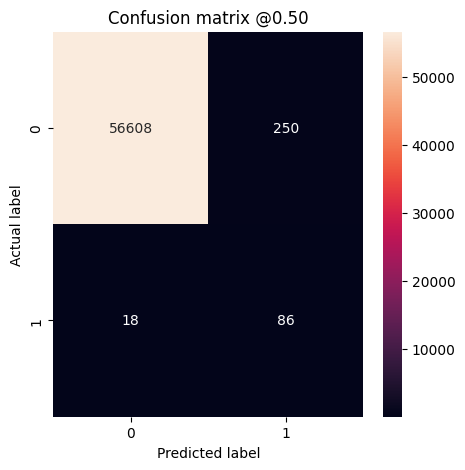

In [41]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions than the baseline model at threshold 50%). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

Compared to the baseline model with changed threshold, the class weighted model is clearly inferior. The superiority of the baseline model is further confirmed by the lower test loss value (cross entropy and mean squared error) and additionally can be seen by plotting the ROC curves of both models together.

### Plot the ROC

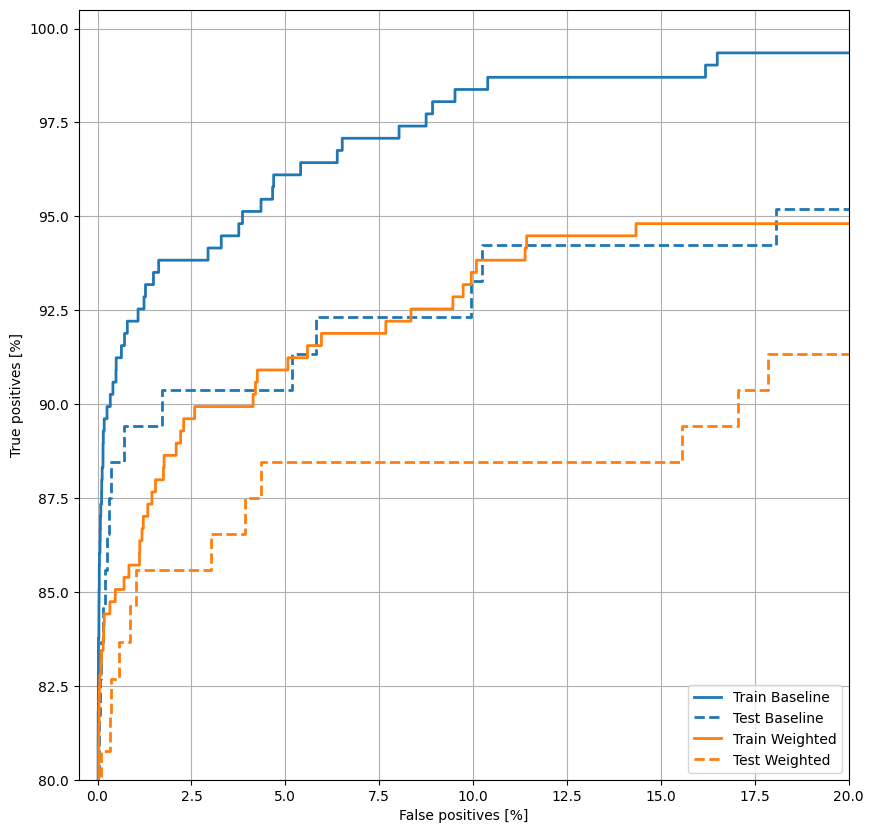

In [42]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the PRC

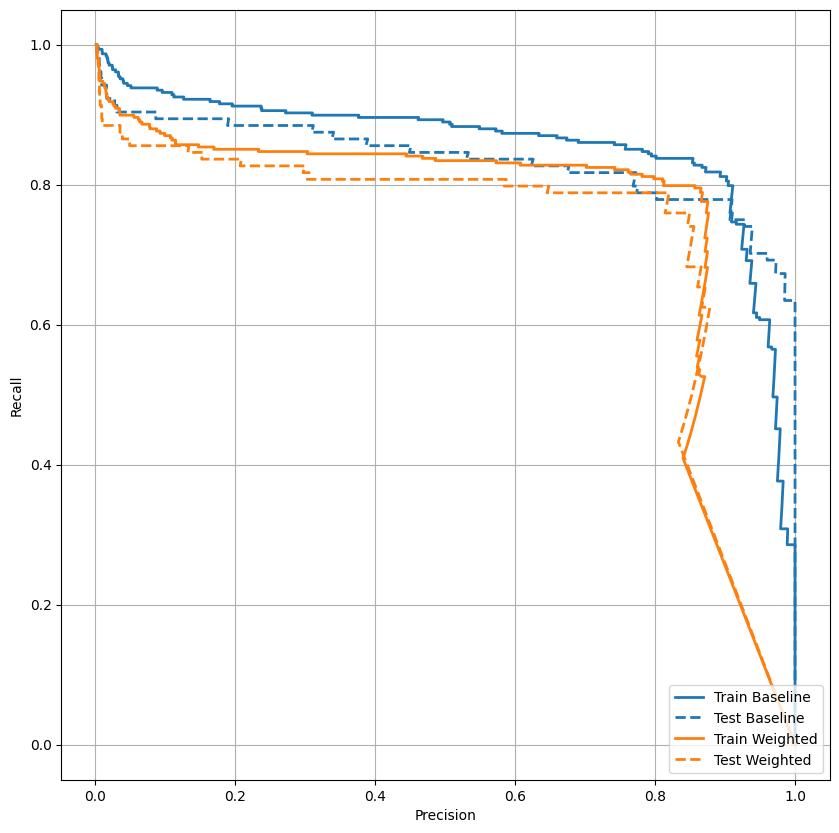

In [43]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [44]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random
indices from the positive examples:

In [45]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181968, 29)

In [46]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363936, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [47]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [48]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.56694806  0.49014045 -0.75291814  0.66106111 -1.67915551 -0.08655032
 -1.31290201  0.39068329 -0.83132769 -2.72856341  2.72449279 -2.38578792
  0.92245239 -4.20733525 -0.58035306 -3.2166798  -5.         -2.08323246
  1.33502262  0.21896083  0.88741251  1.16074723  0.28336572  0.13178371
 -0.50021971  1.46978061  1.03162359  0.24218106  1.17392515]

Label:  [1]


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [49]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [50]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.490234375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [51]:
resampled_steps_per_epoch = int(np.ceil(2.0*neg/BATCH_SIZE))
resampled_steps_per_epoch

278

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps.

In [52]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping()],
    validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


278/278 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - Brier score: 0.1466 - accuracy: 0.7820 - auc: 0.8548 - cross entropy: 0.4632 - fn: 32774.8320 - fp: 41388.2305 - loss: 0.6517 - prc: 0.8194 - precision: 0.6832 - recall: 0.7116 - tn: 158759.8281 - tp: 110751.7812 - val_Brier score: 0.0505 - val_accuracy: 0.9733 - val_auc: 0.9810 - val_cross entropy: 0.2236 - val_fn: 9.0000 - val_fp: 1207.0000 - val_loss: 0.2236 - val_prc: 0.7235 - val_precision: 0.0556 - val_recall: 0.8875 - val_tn: 44282.0000 - val_tp: 71.0000
Epoch 2/100
278/278 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - Brier score: 0.0726 - accuracy: 0.9057 - auc: 0.9612 - cross entropy: 0.2396 - fn: 14983.6025 - fp: 10941.5342 - loss: 0.2396 - prc: 0.9710 - precision: 0.9166 - recall: 0.8936 - tn: 132046.4375 - tp: 128741.0859 - val_Brier score: 0.0251 - val_accuracy: 0.9808 - val_auc: 0.9835 - val_cross entropy: 0.1280 - val_fn: 9.0000 - val_fp: 864.0000 - val_loss: 0.1280 - val_prc: 0.7208 - val_precision: 0.0759 - val_recall: 0.8875 - val_

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data.

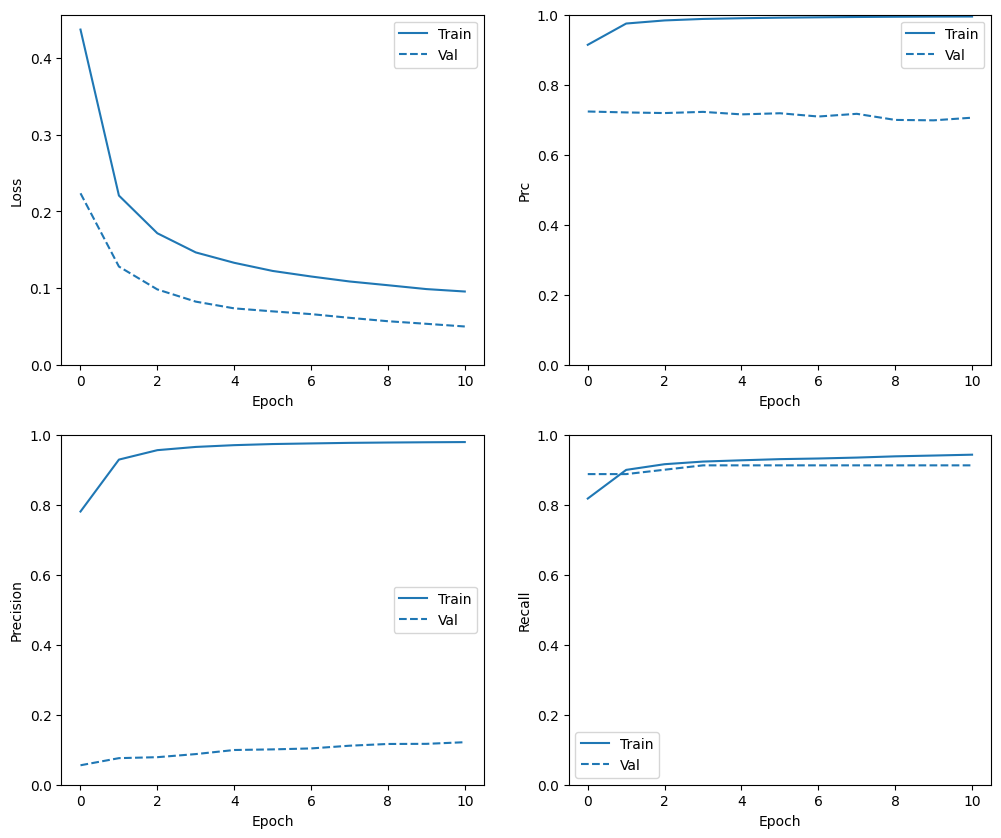

In [53]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [54]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_ds))

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - Brier score: 0.1151 - accuracy: 0.8416 - auc: 0.8170 - cross entropy: 0.4099 - fn: 6686.2383 - fp: 4776.7617 - loss: 1.2759 - prc: 0.4801 - precision: 0.4604 - recall: 0.3851 - tn: 51908.1445 - tp: 4628.3335 - val_Brier score: 0.2037 - val_accuracy: 0.6924 - val_auc: 0.7731 - val_cross entropy: 0.5941 - val_fn: 21.0000 - val_fp: 13994.0000 - val_loss: 0.5941 - val_prc: 0.1941 - val_precision: 0.0042 - val_recall: 0.7375 - val_tn: 31495.0000 - val_tp: 59.0000
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - Brier score: 0.2390 - accuracy: 0.6381 - auc: 0.7006 - cross entropy: 0.7238 - fn: 3540.7144 - fp: 4411.0479 - loss: 0.7238 - prc: 0.7807 - precision: 0.6308 - recall: 0.6709 - tn: 6772.5239 - tp: 7706.1904 - val_Brier score: 0.1992 - val_accuracy: 0.6991 - val_auc: 0.8876 - val_cross entropy: 0.5842 - val_fn: 12.0000 - val_fp: 13701.0000 - val_loss: 0.5842 - val_prc: 0.4967 - val_precision: 0.0049 - val_recall: 0.8500 - v

### Re-check training history

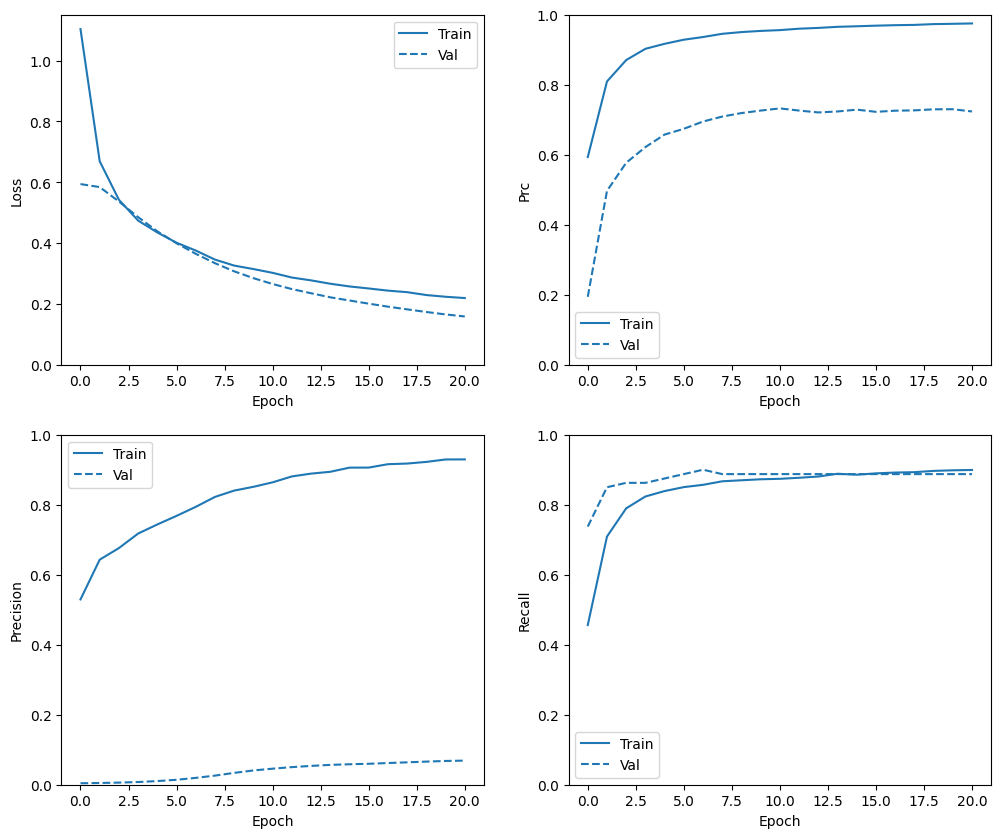

In [55]:
plot_metrics(resampled_history)

### Evaluate metrics

In [56]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


loss :  0.2646985948085785
compile_metrics :  0.2646985948085785

Legitimate Transactions Detected (True Negatives):  55052
Legitimate Transactions Incorrectly Detected (False Positives):  1806
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  90
Total Fraudulent Transactions:  104


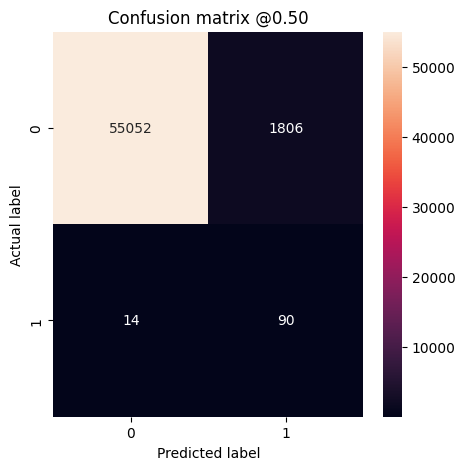

In [57]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

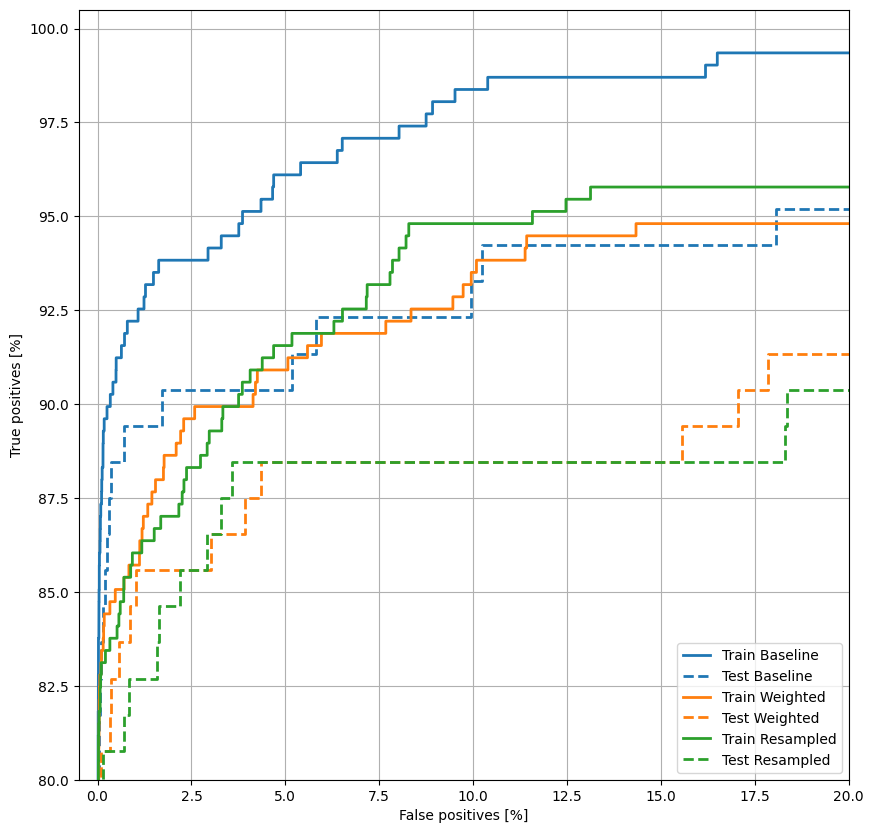

In [58]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


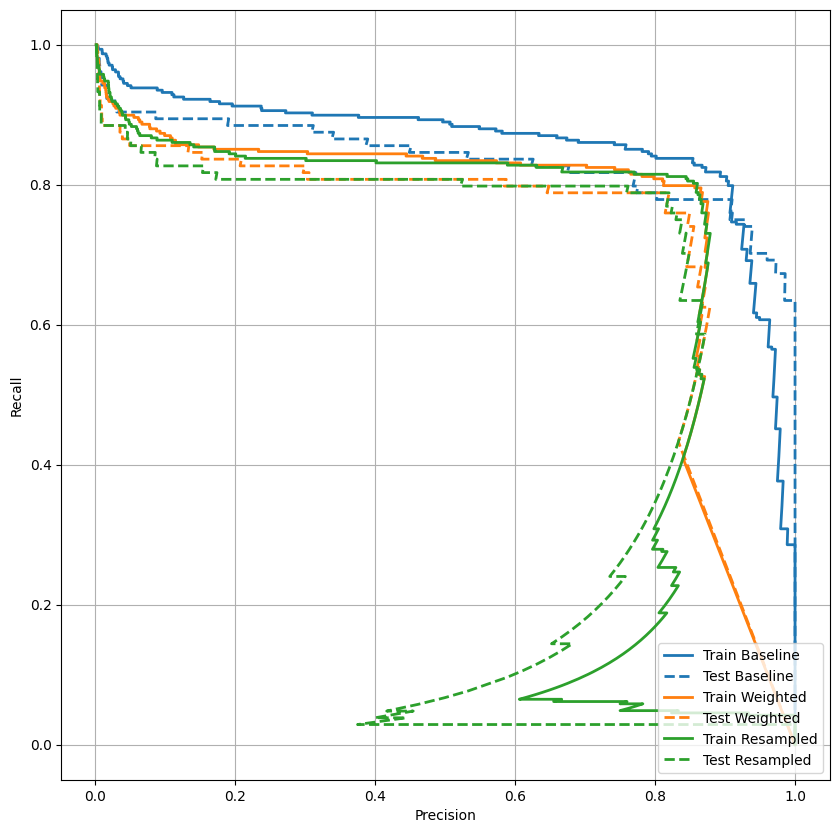

In [59]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.

perform undersampling of the majority class and combine it with upweighting in your training process:

1. Undersample the Majority Class
Undersampling involves randomly selecting a subset of the majority class examples to make the dataset more balanced. Assuming you already separated the positive and negative class features and labels:

In [60]:
# Assuming 'bool_train_labels' is a boolean mask for positive class
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

# Number of positive examples
num_pos = pos_features.shape[0]

In [77]:
"""
# Randomly sample from the negative examples to match the number of positives
indices = np.random.choice(neg_features.shape[0], num_pos, replace=False)
undersampled_neg_features = neg_features[indices]
undersampled_neg_labels = neg_labels[indices]
"""

'\n# Randomly sample from the negative examples to match the number of positives\nindices = np.random.choice(neg_features.shape[0], num_pos, replace=False)\nundersampled_neg_features = neg_features[indices]\nundersampled_neg_labels = neg_labels[indices]\n'

In [78]:
# num_pos

In [79]:
# num_neg = undersampled_neg_features.shape[0]
# num_neg

To achieve moderate imbalance instead of fully balancing the dataset (where minority and majority classes have equal samples), you can select a subset of the majority class such that the proportion of the minority class remains in the range of 20–40% of the total dataset.

In [68]:
# Calculate the current size of each class
num_pos = pos_features.shape[0]  # Minority class count
num_neg = neg_features.shape[0]  # Majority class count

# Define the target percentage of the minority class
target_minority_percentage = 0.3  # Adjust as desired within the 20–40% range

# Calculate the new size for the majority class to achieve the target percentage
target_num_neg = int((num_pos / target_minority_percentage) - num_pos)

In [69]:
# Randomly sample from the majority class to reduce its size
indices = np.random.choice(num_neg, target_num_neg, replace=False)
downsized_neg_features = neg_features[indices]
downsized_neg_labels = neg_labels[indices]

2. Combine Positive and Undersampled Negative Examples
Next, combine the positive examples with the downsampled negative examples to create the balanced training set

In [80]:
"""
# Combine positive and downsampled negative examples
balanced_features = np.concatenate([pos_features, undersampled_neg_features], axis=0)
balanced_labels = np.concatenate([pos_labels, undersampled_neg_labels], axis=0)

# Shuffle the combined dataset
indices = np.arange(balanced_features.shape[0])
np.random.shuffle(indices)

balanced_features = balanced_features[indices]
balanced_labels = balanced_labels[indices]
"""

'\n# Combine positive and downsampled negative examples\nbalanced_features = np.concatenate([pos_features, undersampled_neg_features], axis=0)\nbalanced_labels = np.concatenate([pos_labels, undersampled_neg_labels], axis=0)\n\n# Shuffle the combined dataset\nindices = np.arange(balanced_features.shape[0])\nnp.random.shuffle(indices)\n\nbalanced_features = balanced_features[indices]\nbalanced_labels = balanced_labels[indices]\n'

In [70]:
# Combine the minority class with the downsized majority class
moderately_imbalanced_features = np.concatenate([pos_features, downsized_neg_features], axis=0)
moderately_imbalanced_labels = np.concatenate([pos_labels, downsized_neg_labels], axis=0)

# Shuffle the combined dataset
indices = np.arange(moderately_imbalanced_features.shape[0])
np.random.shuffle(indices)

moderately_imbalanced_features = moderately_imbalanced_features[indices]
moderately_imbalanced_labels = moderately_imbalanced_labels[indices]

3. Upweighting (Adjusting Class Weights)
After undersampling, you apply upweighting to compensate for the reduced number of majority class examples. The class weights need to reflect the original distribution of the data

In [71]:
"""
# Original counts before undersampling
total = len(train_labels)
neg = len(train_labels[~bool_train_labels])  # Original negative class count
pos = len(train_labels[bool_train_labels])   # Positive class count

# Calculate the class weights
weight_for_0 = (1 / neg) * (total / 2.0)  # Majority class weight
weight_for_1 = (1 / pos) * (total / 2.0)  # Minority class weight

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
"""

"\n# Original counts before undersampling\ntotal = len(train_labels)\nneg = len(train_labels[~bool_train_labels])  # Original negative class count\npos = len(train_labels[bool_train_labels])   # Positive class count\n\n# Calculate the class weights\nweight_for_0 = (1 / neg) * (total / 2.0)  # Majority class weight\nweight_for_1 = (1 / pos) * (total / 2.0)  # Minority class weight\n\nclass_weight = {0: weight_for_0, 1: weight_for_1}\n\nprint('Weight for class 0: {:.2f}'.format(weight_for_0))\nprint('Weight for class 1: {:.2f}'.format(weight_for_1))\n"

In [72]:
# Counts after downsampling
new_neg = len(downsized_neg_labels)  # Downsampled majority class count
new_pos = len(pos_labels)  # Minority class count (unchanged)

# Total examples in the new dataset
new_total = new_neg + new_pos

# Calculate class weights based on the new counts
weight_for_0 = (1 / new_neg) * (new_total / 2.0)  # Weight for majority class
weight_for_1 = (1 / new_pos) * (new_total / 2.0)  # Weight for minority class

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Adjusted Weight for class 0: {:.2f}'.format(weight_for_0))
print('Adjusted Weight for class 1: {:.2f}'.format(weight_for_1))

Adjusted Weight for class 0: 0.71
Adjusted Weight for class 1: 1.67


4. Train the Model with Undersampled Data and Class Weights
Train the model using the undersampled dataset (balanced_features, balanced_labels) and include the computed class_weight

In [73]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    # balanced_features,
    # balanced_labels,
    moderately_imbalanced_features,
    moderately_imbalanced_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    class_weight=class_weight  # Apply the class weights
)

# Evaluate the model
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.0061 - accuracy: 0.9938 - auc: 0.5888 - cross entropy: 0.0500 - fn: 338.0000 - fp: 20.0000 - loss: 3.9153 - prc: 0.1883 - precision: 0.7872 - recall: 0.1796 - tn: 57556.0000 - tp: 74.0000 - val_Brier score: 0.0018 - val_accuracy: 0.9982 - val_auc: 0.4957 - val_cross entropy: 0.0152 - val_fn: 80.0000 - val_fp: 0.0000e+00 - val_loss: 0.0152 - val_prc: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 45489.0000 - val_tp: 0.0000e+00
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - Brier score: 0.2911 - accuracy: 0.7018 - auc: 0.5636 - cross entropy: 2.2626 - fn: 306.0000 - fp: 0.0000e+00 - loss: 3.7668 - prc: 0.4311 - precision: 1.0000 - recall: 0.0065 - tn: 718.0000 - tp: 2.0000 - val_Brier score: 0.0018 - val_accuracy: 0.9982 - val_auc: 0.5015 - val_cross entropy: 0.0150 - val_fn: 80.0000 - val_fp: 0.0000e+00 - val_loss: 0.0150 - val_prc: 0.0018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 454

5. Visualize Results
You can visualize the confusion matrix or other metrics to ensure the performance improves on the minority class

Legitimate Transactions Detected (True Negatives):  56840
Legitimate Transactions Incorrectly Detected (False Positives):  18
Fraudulent Transactions Missed (False Negatives):  31
Fraudulent Transactions Detected (True Positives):  73
Total Fraudulent Transactions:  104


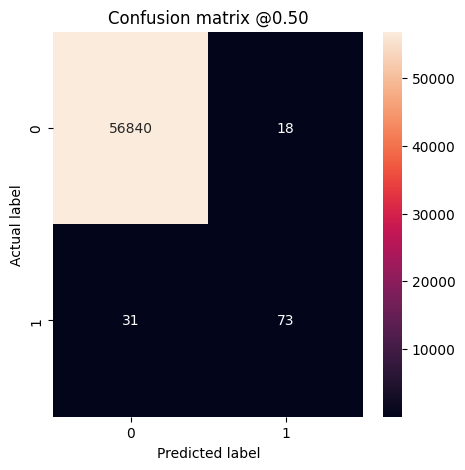

In [74]:
plot_cm(test_labels, test_predictions_weighted)

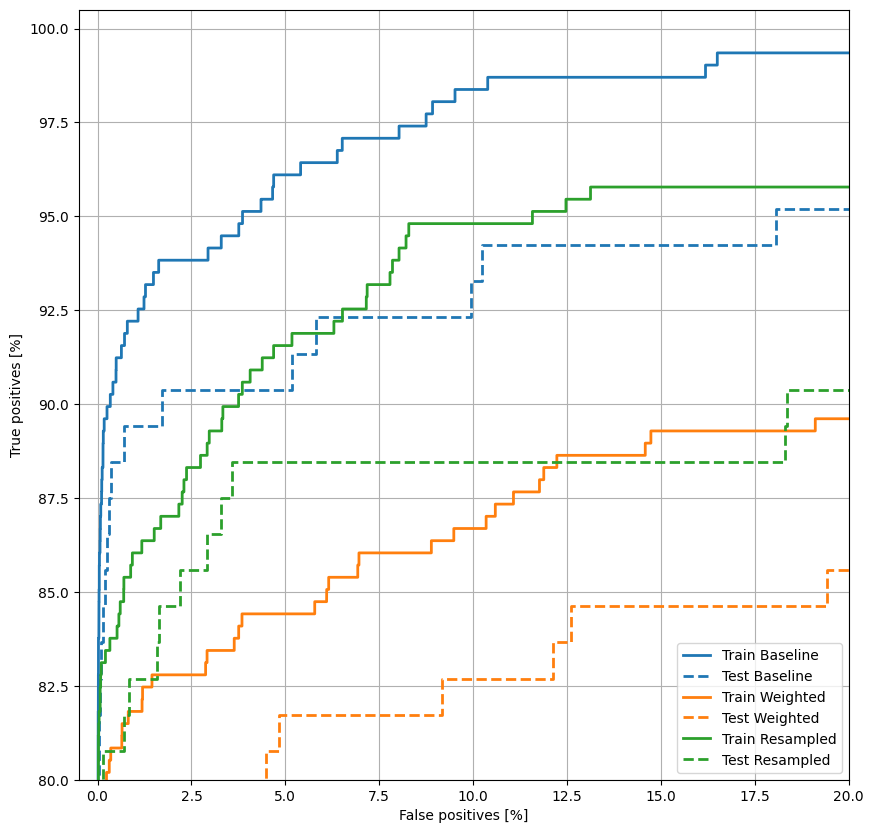

In [75]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

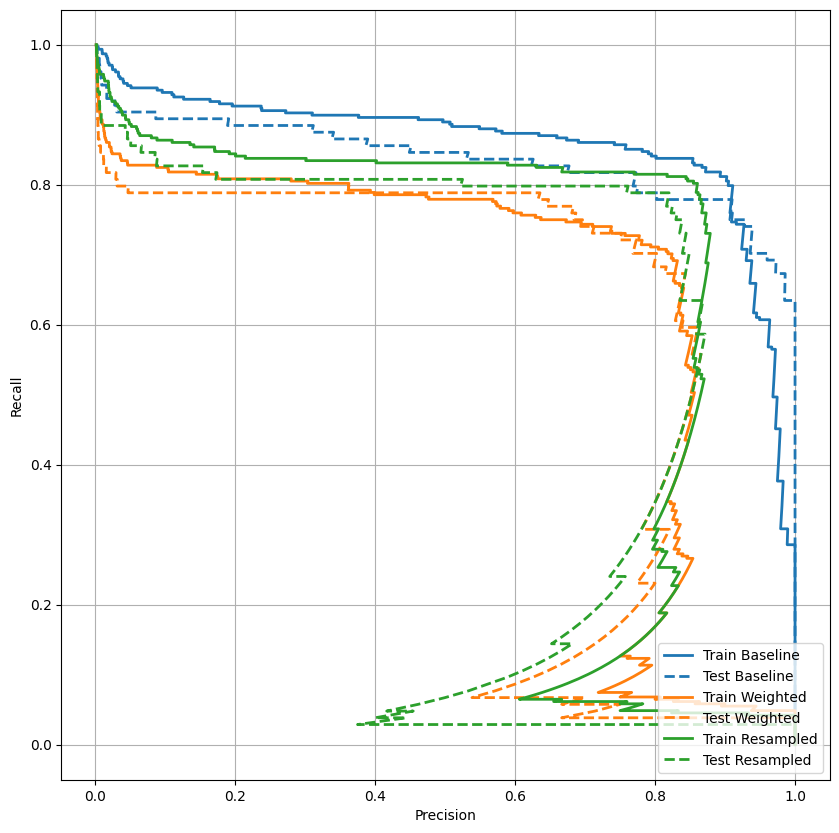

In [76]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

In [81]:
%pip install imbalanced-learn

Import Metrics from imblearn

In [82]:
from imblearn.metrics import (
    sensitivity_score,
    specificity_score,
    geometric_mean_score,
    classification_report_imbalanced
)


Define a Custom Callback for Metrics

Since the imblearn metrics are not directly supported by Keras, you need to define a custom callback that computes these metrics at the end of each epoch.

In [83]:
class ImbalancedMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        self.val_data = val_data  # Validation data for metric computation

    def on_epoch_end(self, epoch, logs=None):
        val_features, val_labels = self.val_data
        val_predictions = (self.model.predict(val_features) > 0.5).astype(int)

        sensitivity = sensitivity_score(val_labels, val_predictions)
        specificity = specificity_score(val_labels, val_predictions)
        geometric_mean = geometric_mean_score(val_labels, val_predictions)

        print(f"\nEpoch {epoch + 1}:")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  Geometric Mean: {geometric_mean:.4f}")


Update Model Training to Include Callback

In [85]:
# Prepare validation data as a tuple
val_data = (val_features, val_labels)

# Create the model
model = make_model(metrics=METRICS)

# Train the model with the custom callback
history = model.fit(
    # train_features,
    # train_labels,
    moderately_imbalanced_features,
    moderately_imbalanced_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    callbacks=[ImbalancedMetricsCallback(val_data)],
    class_weight=class_weight  # Include this if using class weights
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 1:
  Sensitivity: 0.4500
  Specificity: 0.8675
  Geometric Mean: 0.6248
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.0025 - accuracy: 0.9966 - auc: 0.9724 - cross entropy: 0.0100 - fn: 337.0000 - fp: 176.0000 - loss: 0.8082 - prc: 0.5652 - precision: 0.5686 - recall: 0.4077 - tn: 148441.0000 - tp: 232.0000 - val_Brier score: 0.1498 - val_accuracy: 0.8668 - val_auc: 0.6925 - val_cross entropy: 0.4904 - val_fn: 44.0000 - val_fp: 6028.0000 - val_loss: 0.4904 - val_prc: 0.0130 - val_precision: 0.0059 - val_recall: 0.4500 - val_tn: 39461.0000 - val_tp: 36.0000
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

Epoch 2:
  Sensitivity: 0.4750
  Specificity: 0.8692
  Geometric Mean: 0.6425
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.2292 - accuracy: 0.6832 - auc: 0.5724 - cross entropy: 0.6969 - fn: 179.0000 - fp: 146.0000 - loss: 0.8030 - prc: 0.4997 - precision: 0.4691 - recall: 0.4188 - tn: 572.0000 - tp: 129.0000 - val_Brier score: 0.1492 - val_accuracy: 0.8685 - val_auc: 0.7099 - val_cross entropy: 0.4890 - val_fn: 42.0000 - val_fp: 5950.0000 - val_loss: 0.4890 - val_prc: 0.0142 - val_precision: 0.0063 - val_recall: 0.4750 - val_tn: 39539.0000 - val_tp: 38.0000
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.2251 - accuracy: 0.7008 - auc: 0.5930 - cross entropy: 0.6980 - fn: 169.0000 - fp: 138.0000 - loss: 0.7992 - prc: 0.5217 - precision: 0.5018 - recall: 0.4513 - tn: 580.0000 - tp: 139.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 3:
  Sensitivity: 0.4875
  Specificity: 0.8705
  Geometric Mean: 0.6514
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - Brier score: 0.2251 - accuracy: 0.7008 - auc: 0.5930 - cross entropy: 0.6980 - fn: 169.0000 - fp: 138.0000 - loss: 0.7992 - prc: 0.5217 - precision: 0.5018 - recall: 0.4513 - tn: 580.0000 - tp: 139.0000 - val_Brier score: 0.1486 - val_accuracy: 0.8698 - val_auc: 0.7267 - val_cross entropy: 0.4876 - val_fn: 41.0000 - val_fp: 5891.0000 - val_loss: 0.4876 - val_prc: 0.0156 - val_precision: 0.0066 - val_recall: 0.4875 - val_tn: 39598.0000 - val_tp: 39.0000
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.2246 - accuracy: 0.6852 - auc: 0.5908 - cross entropy: 0.6756 - fn: 172.0000 - fp: 151.0000 - loss: 0.7723 - prc: 0.5248 - precision: 0.4739 - recall: 0.4416 - tn: 567.0000 - tp: 136.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 4:
  Sensitivity: 0.5000
  Specificity: 0.8719
  Geometric Mean: 0.6603
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - Brier score: 0.2246 - accuracy: 0.6852 - auc: 0.5908 - cross entropy: 0.6756 - fn: 172.0000 - fp: 151.0000 - loss: 0.7723 - prc: 0.5248 - precision: 0.4739 - recall: 0.4416 - tn: 567.0000 - tp: 136.0000 - val_Brier score: 0.1481 - val_accuracy: 0.8713 - val_auc: 0.7421 - val_cross entropy: 0.4864 - val_fn: 40.0000 - val_fp: 5827.0000 - val_loss: 0.4864 - val_prc: 0.0173 - val_precision: 0.0068 - val_recall: 0.5000 - val_tn: 39662.0000 - val_tp: 40.0000
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - Brier score: 0.2124 - accuracy: 0.7115 - auc: 0.6355 - cross entropy: 0.6458 - fn: 164.0000 - fp: 132.0000 - loss: 0.7297 - prc: 0.5580 - precision: 0.5217 - recall: 0.4675 - tn: 586.0000 - tp: 144.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 5:
  Sensitivity: 0.5125
  Specificity: 0.8731
  Geometric Mean: 0.6689
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.2124 - accuracy: 0.7115 - auc: 0.6355 - cross entropy: 0.6458 - fn: 164.0000 - fp: 132.0000 - loss: 0.7297 - prc: 0.5580 - precision: 0.5217 - recall: 0.4675 - tn: 586.0000 - tp: 144.0000 - val_Brier score: 0.1476 - val_accuracy: 0.8725 - val_auc: 0.7561 - val_cross entropy: 0.4852 - val_fn: 39.0000 - val_fp: 5773.0000 - val_loss: 0.4852 - val_prc: 0.0210 - val_precision: 0.0071 - val_recall: 0.5125 - val_tn: 39716.0000 - val_tp: 41.0000
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - Brier score: 0.2253 - accuracy: 0.6823 - auc: 0.6066 - cross entropy: 0.6765 - fn: 174.0000 - fp: 152.0000 - loss: 0.7571 - prc: 0.5245 - precision: 0.4685 - recall: 0.4351 - tn: 566.0000 - tp: 134.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 6:
  Sensitivity: 0.5500
  Specificity: 0.8744
  Geometric Mean: 0.6935
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2253 - accuracy: 0.6823 - auc: 0.6066 - cross entropy: 0.6765 - fn: 174.0000 - fp: 152.0000 - loss: 0.7571 - prc: 0.5245 - precision: 0.4685 - recall: 0.4351 - tn: 566.0000 - tp: 134.0000 - val_Brier score: 0.1470 - val_accuracy: 0.8738 - val_auc: 0.7695 - val_cross entropy: 0.4839 - val_fn: 36.0000 - val_fp: 5714.0000 - val_loss: 0.4839 - val_prc: 0.0232 - val_precision: 0.0076 - val_recall: 0.5500 - val_tn: 39775.0000 - val_tp: 44.0000
Epoch 7/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 7:
  Sensitivity: 0.5875
  Specificity: 0.8751
  Geometric Mean: 0.7170
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.2115 - accuracy: 0.7115 - auc: 0.6476 - cross entropy: 0.6385 - fn: 157.0000 - fp: 139.0000 - loss: 0.7155 - prc: 0.5672 - precision: 0.5207 - recall: 0.4903 - tn: 579.0000 - tp: 151.0000 - val_Brier score: 0.1465 - val_accuracy: 0.8746 - val_auc: 0.7817 - val_cross entropy: 0.4826 - val_fn: 33.0000 - val_fp: 5683.0000 - val_loss: 0.4826 - val_prc: 0.0256 - val_precision: 0.0082 - val_recall: 0.5875 - val_tn: 39806.0000 - val_tp: 47.0000
Epoch 8/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 8:
  Sensitivity: 0.6125
  Specificity: 0.8764
  Geometric Mean: 0.7327
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2008 - accuracy: 0.7290 - auc: 0.6819 - cross entropy: 0.6095 - fn: 137.0000 - fp: 141.0000 - loss: 0.6614 - prc: 0.6195 - precision: 0.5481 - recall: 0.5552 - tn: 577.0000 - tp: 171.0000 - val_Brier score: 0.1460 - val_accuracy: 0.8759 - val_auc: 0.7930 - val_cross entropy: 0.4814 - val_fn: 31.0000 - val_fp: 5623.0000 - val_loss: 0.4814 - val_prc: 0.0284 - val_precision: 0.0086 - val_recall: 0.6125 - val_tn: 39866.0000 - val_tp: 49.0000
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - Brier score: 0.2045 - accuracy: 0.7290 - auc: 0.6699 - cross entropy: 0.6283 - fn: 144.0000 - fp: 134.0000 - loss: 0.6845 - prc: 0.5818 - precision: 0.5503 - recall: 0.5325 - tn: 584.0000 - tp: 164.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 9:
  Sensitivity: 0.6250
  Specificity: 0.8779
  Geometric Mean: 0.7407
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.2045 - accuracy: 0.7290 - auc: 0.6699 - cross entropy: 0.6283 - fn: 144.0000 - fp: 134.0000 - loss: 0.6845 - prc: 0.5818 - precision: 0.5503 - recall: 0.5325 - tn: 584.0000 - tp: 164.0000 - val_Brier score: 0.1454 - val_accuracy: 0.8775 - val_auc: 0.8045 - val_cross entropy: 0.4801 - val_fn: 30.0000 - val_fp: 5554.0000 - val_loss: 0.4801 - val_prc: 0.0309 - val_precision: 0.0089 - val_recall: 0.6250 - val_tn: 39935.0000 - val_tp: 50.0000
Epoch 10/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 10:
  Sensitivity: 0.6375
  Specificity: 0.8790
  Geometric Mean: 0.7486
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1965 - accuracy: 0.7261 - auc: 0.6910 - cross entropy: 0.5962 - fn: 144.0000 - fp: 137.0000 - loss: 0.6495 - prc: 0.6121 - precision: 0.5449 - recall: 0.5325 - tn: 581.0000 - tp: 164.0000 - val_Brier score: 0.1448 - val_accuracy: 0.8786 - val_auc: 0.8149 - val_cross entropy: 0.4788 - val_fn: 29.0000 - val_fp: 5505.0000 - val_loss: 0.4788 - val_prc: 0.0335 - val_precision: 0.0092 - val_recall: 0.6375 - val_tn: 39984.0000 - val_tp: 51.0000
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - Brier score: 0.1917 - accuracy: 0.7544 - auc: 0.7041 - cross entropy: 0.5934 - fn: 131.0000 - fp: 121.0000 - loss: 0.6528 - prc: 0.6434 - precision: 0.5940 - recall: 0.5747 - tn: 597.0000 - tp: 177.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 11:
  Sensitivity: 0.6375
  Specificity: 0.8802
  Geometric Mean: 0.7491
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1917 - accuracy: 0.7544 - auc: 0.7041 - cross entropy: 0.5934 - fn: 131.0000 - fp: 121.0000 - loss: 0.6528 - prc: 0.6434 - precision: 0.5940 - recall: 0.5747 - tn: 597.0000 - tp: 177.0000 - val_Brier score: 0.1443 - val_accuracy: 0.8798 - val_auc: 0.8246 - val_cross entropy: 0.4775 - val_fn: 29.0000 - val_fp: 5450.0000 - val_loss: 0.4775 - val_prc: 0.0371 - val_precision: 0.0093 - val_recall: 0.6375 - val_tn: 40039.0000 - val_tp: 51.0000
Epoch 12/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 12:
  Sensitivity: 0.6625
  Specificity: 0.8814
  Geometric Mean: 0.7642
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1947 - accuracy: 0.7271 - auc: 0.6918 - cross entropy: 0.5894 - fn: 143.0000 - fp: 137.0000 - loss: 0.6475 - prc: 0.6137 - precision: 0.5464 - recall: 0.5357 - tn: 581.0000 - tp: 165.0000 - val_Brier score: 0.1438 - val_accuracy: 0.8811 - val_auc: 0.8336 - val_cross entropy: 0.4763 - val_fn: 27.0000 - val_fp: 5393.0000 - val_loss: 0.4763 - val_prc: 0.0409 - val_precision: 0.0097 - val_recall: 0.6625 - val_tn: 40096.0000 - val_tp: 53.0000
Epoch 13/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 13:
  Sensitivity: 0.6750
  Specificity: 0.8824
  Geometric Mean: 0.7718
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.2033 - accuracy: 0.7261 - auc: 0.6739 - cross entropy: 0.6139 - fn: 138.0000 - fp: 143.0000 - loss: 0.6678 - prc: 0.6145 - precision: 0.5431 - recall: 0.5519 - tn: 575.0000 - tp: 170.0000 - val_Brier score: 0.1433 - val_accuracy: 0.8821 - val_auc: 0.8426 - val_cross entropy: 0.4751 - val_fn: 26.0000 - val_fp: 5348.0000 - val_loss: 0.4751 - val_prc: 0.0444 - val_precision: 0.0100 - val_recall: 0.6750 - val_tn: 40141.0000 - val_tp: 54.0000
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - Brier score: 0.1870 - accuracy: 0.7534 - auc: 0.7230 - cross entropy: 0.5753 - fn: 130.0000 - fp: 123.0000 - loss: 0.6168 - prc: 0.6457 - precision: 0.5914 - recall: 0.5779 - tn: 595.0000 - tp: 178.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Epoch 14:
  Sensitivity: 0.7125
  Specificity: 0.8835
  Geometric Mean: 0.7934
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - Brier score: 0.1870 - accuracy: 0.7534 - auc: 0.7230 - cross entropy: 0.5753 - fn: 130.0000 - fp: 123.0000 - loss: 0.6168 - prc: 0.6457 - precision: 0.5914 - recall: 0.5779 - tn: 595.0000 - tp: 178.0000 - val_Brier score: 0.1427 - val_accuracy: 0.8832 - val_auc: 0.8505 - val_cross entropy: 0.4738 - val_fn: 23.0000 - val_fp: 5301.0000 - val_loss: 0.4738 - val_prc: 0.0484 - val_precision: 0.0106 - val_recall: 0.7125 - val_tn: 40188.0000 - val_tp: 57.0000
Epoch 15/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Epoch 15:
  Sensitivity: 0.7125
  Specificity: 0.8848
  Geometric Mean: 0.7940
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - Brier score: 0.1886 - accuracy: 0.7290 - auc: 0.7264 - cross entropy: 0.5720 - fn: 128.0000 - fp: 150.0000 - loss: 0.6123 - prc: 0.6551 - precision: 0.5455 - recall: 0.5844 - tn: 568.0000 - tp: 180.0000 - val_Brier score: 0.1421 - val_accuracy: 0.8845 - val_auc: 0.8573 - val_cross entropy: 0.4725 - val_fn: 23.0000 - val_fp: 5242.0000 - val_loss: 0.4725 - val_prc: 0.0531 - val_precision: 0.0108 - val_recall: 0.7125 - val_tn: 40247.0000 - val_tp: 57.0000
Epoch 16/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Epoch 16:
  Sensitivity: 0.7125
  Specificity: 0.8862
  Geometric Mean: 0.7946
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1858 - accuracy: 0.7573 - auc: 0.7224 - cross entropy: 0.5788 - fn: 122.0000 - fp: 127.0000 - loss: 0.6205 - prc: 0.6602 - precision: 0.5942 - recall: 0.6039 - tn: 591.0000 - tp: 186.0000 - val_Brier score: 0.1416 - val_accuracy: 0.8859 - val_auc: 0.8642 - val_cross entropy: 0.4711 - val_fn: 23.0000 - val_fp: 5178.0000 - val_loss: 0.4711 - val_prc: 0.0561 - val_precision: 0.0109 - val_recall: 0.7125 - val_tn: 40311.0000 - val_tp: 57.0000
Epoch 17/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 17:
  Sensitivity: 0.7125
  Specificity: 0.8872
  Geometric Mean: 0.7951
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1817 - accuracy: 0.7524 - auc: 0.7420 - cross entropy: 0.5633 - fn: 127.0000 - fp: 127.0000 - loss: 0.5985 - prc: 0.6573 - precision: 0.5877 - recall: 0.5877 - tn: 591.0000 - tp: 181.0000 - val_Brier score: 0.1410 - val_accuracy: 0.8869 - val_auc: 0.8701 - val_cross entropy: 0.4698 - val_fn: 23.0000 - val_fp: 5130.0000 - val_loss: 0.4698 - val_prc: 0.0674 - val_precision: 0.0110 - val_recall: 0.7125 - val_tn: 40359.0000 - val_tp: 57.0000
Epoch 18/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 18:
  Sensitivity: 0.7125
  Specificity: 0.8882
  Geometric Mean: 0.7955
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1852 - accuracy: 0.7544 - auc: 0.7160 - cross entropy: 0.5618 - fn: 124.0000 - fp: 128.0000 - loss: 0.6054 - prc: 0.6729 - precision: 0.5897 - recall: 0.5974 - tn: 590.0000 - tp: 184.0000 - val_Brier score: 0.1404 - val_accuracy: 0.8879 - val_auc: 0.8751 - val_cross entropy: 0.4683 - val_fn: 23.0000 - val_fp: 5084.0000 - val_loss: 0.4683 - val_prc: 0.0728 - val_precision: 0.0111 - val_recall: 0.7125 - val_tn: 40405.0000 - val_tp: 57.0000
Epoch 19/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 19:
  Sensitivity: 0.7250
  Specificity: 0.8896
  Geometric Mean: 0.8031
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1800 - accuracy: 0.7632 - auc: 0.7365 - cross entropy: 0.5610 - fn: 122.0000 - fp: 121.0000 - loss: 0.5964 - prc: 0.6700 - precision: 0.6059 - recall: 0.6039 - tn: 597.0000 - tp: 186.0000 - val_Brier score: 0.1398 - val_accuracy: 0.8893 - val_auc: 0.8806 - val_cross entropy: 0.4669 - val_fn: 22.0000 - val_fp: 5022.0000 - val_loss: 0.4669 - val_prc: 0.0768 - val_precision: 0.0114 - val_recall: 0.7250 - val_tn: 40467.0000 - val_tp: 58.0000
Epoch 20/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - Brier score: 0.1739 - accuracy: 0.7593 - auc: 0.7562 - cross entropy: 0.5283 - fn: 117.0000 - fp: 130.0000 - loss: 0.5638 - prc: 0.6957 - precision: 0.5950 - recall: 0.6201 - tn: 588.0000 - tp: 191.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 20:
  Sensitivity: 0.7375
  Specificity: 0.8909
  Geometric Mean: 0.8106
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - Brier score: 0.1739 - accuracy: 0.7593 - auc: 0.7562 - cross entropy: 0.5283 - fn: 117.0000 - fp: 130.0000 - loss: 0.5638 - prc: 0.6957 - precision: 0.5950 - recall: 0.6201 - tn: 588.0000 - tp: 191.0000 - val_Brier score: 0.1391 - val_accuracy: 0.8907 - val_auc: 0.8848 - val_cross entropy: 0.4654 - val_fn: 21.0000 - val_fp: 4961.0000 - val_loss: 0.4654 - val_prc: 0.0840 - val_precision: 0.0118 - val_recall: 0.7375 - val_tn: 40528.0000 - val_tp: 59.0000
Epoch 21/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 21:
  Sensitivity: 0.7625
  Specificity: 0.8921
  Geometric Mean: 0.8247
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.1668 - accuracy: 0.7797 - auc: 0.7841 - cross entropy: 0.5167 - fn: 105.0000 - fp: 121.0000 - loss: 0.5370 - prc: 0.7366 - precision: 0.6265 - recall: 0.6591 - tn: 597.0000 - tp: 203.0000 - val_Brier score: 0.1385 - val_accuracy: 0.8918 - val_auc: 0.8885 - val_cross entropy: 0.4640 - val_fn: 19.0000 - val_fp: 4910.0000 - val_loss: 0.4640 - val_prc: 0.0894 - val_precision: 0.0123 - val_recall: 0.7625 - val_tn: 40579.0000 - val_tp: 61.0000
Epoch 22/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 22:
  Sensitivity: 0.7750
  Specificity: 0.8932
  Geometric Mean: 0.8320
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1717 - accuracy: 0.7690 - auc: 0.7740 - cross entropy: 0.5385 - fn: 112.0000 - fp: 125.0000 - loss: 0.5589 - prc: 0.6999 - precision: 0.6106 - recall: 0.6364 - tn: 593.0000 - tp: 196.0000 - val_Brier score: 0.1378 - val_accuracy: 0.8930 - val_auc: 0.8920 - val_cross entropy: 0.4624 - val_fn: 18.0000 - val_fp: 4859.0000 - val_loss: 0.4624 - val_prc: 0.0957 - val_precision: 0.0126 - val_recall: 0.7750 - val_tn: 40630.0000 - val_tp: 62.0000
Epoch 23/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

Epoch 23:
  Sensitivity: 0.8125
  Specificity: 0.8945
  Geometric Mean: 0.8525
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - Brier score: 0.1887 - accuracy: 0.7563 - auc: 0.7072 - cross entropy: 0.5746 - fn: 128.0000 - fp: 122.0000 - loss: 0.6242 - prc: 0.6607 - precision: 0.5960 - recall: 0.5844 - tn: 596.0000 - tp: 180.0000 - val_Brier score: 0.1372 - val_accuracy: 0.8943 - val_auc: 0.8955 - val_cross entropy: 0.4608 - val_fn: 15.0000 - val_fp: 4800.0000 - val_loss: 0.4608 - val_prc: 0.1091 - val_precision: 0.0134 - val_recall: 0.8125 - val_tn: 40689.0000 - val_tp: 65.0000
Epoch 24/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 24:
  Sensitivity: 0.8250
  Specificity: 0.8958
  Geometric Mean: 0.8596
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1730 - accuracy: 0.7797 - auc: 0.7621 - cross entropy: 0.5343 - fn: 108.0000 - fp: 118.0000 - loss: 0.5611 - prc: 0.7027 - precision: 0.6289 - recall: 0.6494 - tn: 600.0000 - tp: 200.0000 - val_Brier score: 0.1365 - val_accuracy: 0.8956 - val_auc: 0.8982 - val_cross entropy: 0.4593 - val_fn: 14.0000 - val_fp: 4742.0000 - val_loss: 0.4593 - val_prc: 0.1126 - val_precision: 0.0137 - val_recall: 0.8250 - val_tn: 40747.0000 - val_tp: 66.0000
Epoch 25/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.1715 - accuracy: 0.7749 - auc: 0.7718 - cross entropy: 0.5347 - fn: 109.0000 - fp: 122.0000 - loss: 0.5550 - prc: 0.7156 - precision: 0.6199 - recall: 0.6461 - tn: 596.0000 - tp: 199.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 25:
  Sensitivity: 0.8250
  Specificity: 0.8970
  Geometric Mean: 0.8603
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1715 - accuracy: 0.7749 - auc: 0.7718 - cross entropy: 0.5347 - fn: 109.0000 - fp: 122.0000 - loss: 0.5550 - prc: 0.7156 - precision: 0.6199 - recall: 0.6461 - tn: 596.0000 - tp: 199.0000 - val_Brier score: 0.1359 - val_accuracy: 0.8969 - val_auc: 0.9012 - val_cross entropy: 0.4577 - val_fn: 14.0000 - val_fp: 4685.0000 - val_loss: 0.4577 - val_prc: 0.1211 - val_precision: 0.0139 - val_recall: 0.8250 - val_tn: 40804.0000 - val_tp: 66.0000
Epoch 26/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.1689 - accuracy: 0.7719 - auc: 0.7622 - cross entropy: 0.5166 - fn: 109.0000 - fp: 125.0000 - loss: 0.5440 - prc: 0.7233 - precision: 0.6142 - recall: 0.6461 - tn: 593.0000 - tp: 199.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 26:
  Sensitivity: 0.8250
  Specificity: 0.8982
  Geometric Mean: 0.8608
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1689 - accuracy: 0.7719 - auc: 0.7622 - cross entropy: 0.5166 - fn: 109.0000 - fp: 125.0000 - loss: 0.5440 - prc: 0.7233 - precision: 0.6142 - recall: 0.6461 - tn: 593.0000 - tp: 199.0000 - val_Brier score: 0.1352 - val_accuracy: 0.8981 - val_auc: 0.9033 - val_cross entropy: 0.4562 - val_fn: 14.0000 - val_fp: 4629.0000 - val_loss: 0.4562 - val_prc: 0.1258 - val_precision: 0.0141 - val_recall: 0.8250 - val_tn: 40860.0000 - val_tp: 66.0000
Epoch 27/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 27:
  Sensitivity: 0.8250
  Specificity: 0.8996
  Geometric Mean: 0.8615
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1770 - accuracy: 0.7671 - auc: 0.7568 - cross entropy: 0.5454 - fn: 109.0000 - fp: 130.0000 - loss: 0.5679 - prc: 0.6991 - precision: 0.6049 - recall: 0.6461 - tn: 588.0000 - tp: 199.0000 - val_Brier score: 0.1345 - val_accuracy: 0.8994 - val_auc: 0.9055 - val_cross entropy: 0.4545 - val_fn: 14.0000 - val_fp: 4568.0000 - val_loss: 0.4545 - val_prc: 0.1353 - val_precision: 0.0142 - val_recall: 0.8250 - val_tn: 40921.0000 - val_tp: 66.0000
Epoch 28/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.1656 - accuracy: 0.7749 - auc: 0.8000 - cross entropy: 0.5086 - fn: 102.0000 - fp: 129.0000 - loss: 0.5211 - prc: 0.7367 - precision: 0.6149 - recall: 0.6688 - tn: 589.0000 - tp: 206.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 28:
  Sensitivity: 0.8250
  Specificity: 0.9007
  Geometric Mean: 0.8620
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1656 - accuracy: 0.7749 - auc: 0.8000 - cross entropy: 0.5086 - fn: 102.0000 - fp: 129.0000 - loss: 0.5211 - prc: 0.7367 - precision: 0.6149 - recall: 0.6688 - tn: 589.0000 - tp: 206.0000 - val_Brier score: 0.1338 - val_accuracy: 0.9005 - val_auc: 0.9078 - val_cross entropy: 0.4527 - val_fn: 14.0000 - val_fp: 4518.0000 - val_loss: 0.4527 - val_prc: 0.1407 - val_precision: 0.0144 - val_recall: 0.8250 - val_tn: 40971.0000 - val_tp: 66.0000
Epoch 29/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 29:
  Sensitivity: 0.8250
  Specificity: 0.9023
  Geometric Mean: 0.8628
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1662 - accuracy: 0.7924 - auc: 0.7860 - cross entropy: 0.5176 - fn: 101.0000 - fp: 112.0000 - loss: 0.5329 - prc: 0.7393 - precision: 0.6489 - recall: 0.6721 - tn: 606.0000 - tp: 207.0000 - val_Brier score: 0.1330 - val_accuracy: 0.9022 - val_auc: 0.9097 - val_cross entropy: 0.4509 - val_fn: 14.0000 - val_fp: 4444.0000 - val_loss: 0.4509 - val_prc: 0.1553 - val_precision: 0.0146 - val_recall: 0.8250 - val_tn: 41045.0000 - val_tp: 66.0000
Epoch 30/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 30:
  Sensitivity: 0.8375
  Specificity: 0.9035
  Geometric Mean: 0.8699
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1556 - accuracy: 0.7973 - auc: 0.8081 - cross entropy: 0.4908 - fn: 98.0000 - fp: 110.0000 - loss: 0.5051 - prc: 0.7667 - precision: 0.6562 - recall: 0.6818 - tn: 608.0000 - tp: 210.0000 - val_Brier score: 0.1323 - val_accuracy: 0.9034 - val_auc: 0.9116 - val_cross entropy: 0.4492 - val_fn: 13.0000 - val_fp: 4389.0000 - val_loss: 0.4492 - val_prc: 0.1611 - val_precision: 0.0150 - val_recall: 0.8375 - val_tn: 41100.0000 - val_tp: 67.0000
Epoch 31/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - Brier score: 0.1607 - accuracy: 0.7836 - auc: 0.7968 - cross entropy: 0.5124 - fn: 103.0000 - fp: 119.0000 - loss: 0.5263 - prc: 0.7412 - precision: 0.6327 - recall: 0.6656 - tn: 599.0000 - tp: 205.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 31:
  Sensitivity: 0.8375
  Specificity: 0.9049
  Geometric Mean: 0.8705
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1607 - accuracy: 0.7836 - auc: 0.7968 - cross entropy: 0.5124 - fn: 103.0000 - fp: 119.0000 - loss: 0.5263 - prc: 0.7412 - precision: 0.6327 - recall: 0.6656 - tn: 599.0000 - tp: 205.0000 - val_Brier score: 0.1315 - val_accuracy: 0.9048 - val_auc: 0.9130 - val_cross entropy: 0.4473 - val_fn: 13.0000 - val_fp: 4327.0000 - val_loss: 0.4473 - val_prc: 0.1793 - val_precision: 0.0152 - val_recall: 0.8375 - val_tn: 41162.0000 - val_tp: 67.0000
Epoch 32/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 32:
  Sensitivity: 0.8375
  Specificity: 0.9062
  Geometric Mean: 0.8712
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1664 - accuracy: 0.7846 - auc: 0.7801 - cross entropy: 0.5198 - fn: 99.0000 - fp: 122.0000 - loss: 0.5341 - prc: 0.7387 - precision: 0.6314 - recall: 0.6786 - tn: 596.0000 - tp: 209.0000 - val_Brier score: 0.1307 - val_accuracy: 0.9061 - val_auc: 0.9148 - val_cross entropy: 0.4455 - val_fn: 13.0000 - val_fp: 4268.0000 - val_loss: 0.4455 - val_prc: 0.1933 - val_precision: 0.0155 - val_recall: 0.8375 - val_tn: 41221.0000 - val_tp: 67.0000
Epoch 33/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 33:
  Sensitivity: 0.8375
  Specificity: 0.9076
  Geometric Mean: 0.8719
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1608 - accuracy: 0.7836 - auc: 0.7906 - cross entropy: 0.4940 - fn: 102.0000 - fp: 120.0000 - loss: 0.5142 - prc: 0.7600 - precision: 0.6319 - recall: 0.6688 - tn: 598.0000 - tp: 206.0000 - val_Brier score: 0.1300 - val_accuracy: 0.9075 - val_auc: 0.9161 - val_cross entropy: 0.4436 - val_fn: 13.0000 - val_fp: 4202.0000 - val_loss: 0.4436 - val_prc: 0.1966 - val_precision: 0.0157 - val_recall: 0.8375 - val_tn: 41287.0000 - val_tp: 67.0000
Epoch 34/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 34:
  Sensitivity: 0.8500
  Specificity: 0.9087
  Geometric Mean: 0.8789
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1489 - accuracy: 0.8119 - auc: 0.8336 - cross entropy: 0.4737 - fn: 86.0000 - fp: 107.0000 - loss: 0.4767 - prc: 0.7873 - precision: 0.6748 - recall: 0.7208 - tn: 611.0000 - tp: 222.0000 - val_Brier score: 0.1292 - val_accuracy: 0.9086 - val_auc: 0.9171 - val_cross entropy: 0.4418 - val_fn: 12.0000 - val_fp: 4154.0000 - val_loss: 0.4418 - val_prc: 0.2100 - val_precision: 0.0161 - val_recall: 0.8500 - val_tn: 41335.0000 - val_tp: 68.0000
Epoch 35/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 35:
  Sensitivity: 0.8500
  Specificity: 0.9100
  Geometric Mean: 0.8795
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1625 - accuracy: 0.7914 - auc: 0.7844 - cross entropy: 0.5072 - fn: 98.0000 - fp: 116.0000 - loss: 0.5269 - prc: 0.7469 - precision: 0.6442 - recall: 0.6818 - tn: 602.0000 - tp: 210.0000 - val_Brier score: 0.1284 - val_accuracy: 0.9099 - val_auc: 0.9187 - val_cross entropy: 0.4399 - val_fn: 12.0000 - val_fp: 4095.0000 - val_loss: 0.4399 - val_prc: 0.2213 - val_precision: 0.0163 - val_recall: 0.8500 - val_tn: 41394.0000 - val_tp: 68.0000
Epoch 36/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 36:
  Sensitivity: 0.8500
  Specificity: 0.9110
  Geometric Mean: 0.8800
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1513 - accuracy: 0.7973 - auc: 0.8379 - cross entropy: 0.4775 - fn: 78.0000 - fp: 130.0000 - loss: 0.4701 - prc: 0.7953 - precision: 0.6389 - recall: 0.7468 - tn: 588.0000 - tp: 230.0000 - val_Brier score: 0.1276 - val_accuracy: 0.9109 - val_auc: 0.9199 - val_cross entropy: 0.4379 - val_fn: 12.0000 - val_fp: 4048.0000 - val_loss: 0.4379 - val_prc: 0.2340 - val_precision: 0.0165 - val_recall: 0.8500 - val_tn: 41441.0000 - val_tp: 68.0000
Epoch 37/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 37:
  Sensitivity: 0.8500
  Specificity: 0.9124
  Geometric Mean: 0.8806
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1472 - accuracy: 0.8109 - auc: 0.8319 - cross entropy: 0.4592 - fn: 89.0000 - fp: 105.0000 - loss: 0.4716 - prc: 0.7985 - precision: 0.6759 - recall: 0.7110 - tn: 613.0000 - tp: 219.0000 - val_Brier score: 0.1268 - val_accuracy: 0.9123 - val_auc: 0.9212 - val_cross entropy: 0.4360 - val_fn: 12.0000 - val_fp: 3985.0000 - val_loss: 0.4360 - val_prc: 0.2403 - val_precision: 0.0168 - val_recall: 0.8500 - val_tn: 41504.0000 - val_tp: 68.0000
Epoch 38/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - Brier score: 0.1521 - accuracy: 0.8148 - auc: 0.8112 - cross entropy: 0.4767 - fn: 92.0000 - fp: 98.0000 - loss: 0.4947 - prc: 0.7745 - precision: 0.6879 - recall: 0.7013 - tn: 620.0000 - tp: 216.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 38:
  Sensitivity: 0.8500
  Specificity: 0.9137
  Geometric Mean: 0.8813
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1521 - accuracy: 0.8148 - auc: 0.8112 - cross entropy: 0.4767 - fn: 92.0000 - fp: 98.0000 - loss: 0.4947 - prc: 0.7745 - precision: 0.6879 - recall: 0.7013 - tn: 620.0000 - tp: 216.0000 - val_Brier score: 0.1260 - val_accuracy: 0.9136 - val_auc: 0.9222 - val_cross entropy: 0.4341 - val_fn: 12.0000 - val_fp: 3925.0000 - val_loss: 0.4341 - val_prc: 0.2469 - val_precision: 0.0170 - val_recall: 0.8500 - val_tn: 41564.0000 - val_tp: 68.0000
Epoch 39/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 39:
  Sensitivity: 0.8500
  Specificity: 0.9147
  Geometric Mean: 0.8818
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1522 - accuracy: 0.8158 - auc: 0.8199 - cross entropy: 0.4868 - fn: 83.0000 - fp: 106.0000 - loss: 0.4869 - prc: 0.7767 - precision: 0.6798 - recall: 0.7305 - tn: 612.0000 - tp: 225.0000 - val_Brier score: 0.1251 - val_accuracy: 0.9146 - val_auc: 0.9231 - val_cross entropy: 0.4321 - val_fn: 12.0000 - val_fp: 3879.0000 - val_loss: 0.4321 - val_prc: 0.2582 - val_precision: 0.0172 - val_recall: 0.8500 - val_tn: 41610.0000 - val_tp: 68.0000
Epoch 40/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.1500 - accuracy: 0.8051 - auc: 0.8167 - cross entropy: 0.4751 - fn: 100.0000 - fp: 100.0000 - loss: 0.4937 - prc: 0.7680 - precision: 0.6753 - recall: 0.6753 - tn: 618.0000 - tp: 208.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 40:
  Sensitivity: 0.8500
  Specificity: 0.9160
  Geometric Mean: 0.8824
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1500 - accuracy: 0.8051 - auc: 0.8167 - cross entropy: 0.4751 - fn: 100.0000 - fp: 100.0000 - loss: 0.4937 - prc: 0.7680 - precision: 0.6753 - recall: 0.6753 - tn: 618.0000 - tp: 208.0000 - val_Brier score: 0.1243 - val_accuracy: 0.9159 - val_auc: 0.9244 - val_cross entropy: 0.4301 - val_fn: 12.0000 - val_fp: 3822.0000 - val_loss: 0.4301 - val_prc: 0.2711 - val_precision: 0.0175 - val_recall: 0.8500 - val_tn: 41667.0000 - val_tp: 68.0000
Epoch 41/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 41:
  Sensitivity: 0.8500
  Specificity: 0.9172
  Geometric Mean: 0.8830
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1516 - accuracy: 0.8109 - auc: 0.8249 - cross entropy: 0.4873 - fn: 80.0000 - fp: 114.0000 - loss: 0.4874 - prc: 0.7948 - precision: 0.6667 - recall: 0.7403 - tn: 604.0000 - tp: 228.0000 - val_Brier score: 0.1235 - val_accuracy: 0.9171 - val_auc: 0.9255 - val_cross entropy: 0.4281 - val_fn: 12.0000 - val_fp: 3765.0000 - val_loss: 0.4281 - val_prc: 0.2766 - val_precision: 0.0177 - val_recall: 0.8500 - val_tn: 41724.0000 - val_tp: 68.0000
Epoch 42/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - Brier score: 0.1570 - accuracy: 0.7992 - auc: 0.8182 - cross entropy: 0.4948 - fn: 86.0000 - fp: 120.0000 - loss: 0.4952 - prc: 0.7738 - precision: 0.6491 - recall: 0.7208 - tn: 598.0000 - tp: 222.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step

Epoch 42:
  Sensitivity: 0.8500
  Specificity: 0.9183
  Geometric Mean: 0.8835
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - Brier score: 0.1570 - accuracy: 0.7992 - auc: 0.8182 - cross entropy: 0.4948 - fn: 86.0000 - fp: 120.0000 - loss: 0.4952 - prc: 0.7738 - precision: 0.6491 - recall: 0.7208 - tn: 598.0000 - tp: 222.0000 - val_Brier score: 0.1227 - val_accuracy: 0.9182 - val_auc: 0.9265 - val_cross entropy: 0.4261 - val_fn: 12.0000 - val_fp: 3715.0000 - val_loss: 0.4261 - val_prc: 0.2821 - val_precision: 0.0180 - val_recall: 0.8500 - val_tn: 41774.0000 - val_tp: 68.0000
Epoch 43/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 43:
  Sensitivity: 0.8500
  Specificity: 0.9194
  Geometric Mean: 0.8840
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - Brier score: 0.1494 - accuracy: 0.8148 - auc: 0.8198 - cross entropy: 0.4717 - fn: 89.0000 - fp: 101.0000 - loss: 0.4865 - prc: 0.7929 - precision: 0.6844 - recall: 0.7110 - tn: 617.0000 - tp: 219.0000 - val_Brier score: 0.1218 - val_accuracy: 0.9193 - val_auc: 0.9274 - val_cross entropy: 0.4241 - val_fn: 12.0000 - val_fp: 3665.0000 - val_loss: 0.4241 - val_prc: 0.2999 - val_precision: 0.0182 - val_recall: 0.8500 - val_tn: 41824.0000 - val_tp: 68.0000
Epoch 44/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 44:
  Sensitivity: 0.8500
  Specificity: 0.9207
  Geometric Mean: 0.8846
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1425 - accuracy: 0.8207 - auc: 0.8405 - cross entropy: 0.4559 - fn: 85.0000 - fp: 99.0000 - loss: 0.4590 - prc: 0.8019 - precision: 0.6925 - recall: 0.7240 - tn: 619.0000 - tp: 223.0000 - val_Brier score: 0.1210 - val_accuracy: 0.9206 - val_auc: 0.9284 - val_cross entropy: 0.4221 - val_fn: 12.0000 - val_fp: 3607.0000 - val_loss: 0.4221 - val_prc: 0.3089 - val_precision: 0.0185 - val_recall: 0.8500 - val_tn: 41882.0000 - val_tp: 68.0000
Epoch 45/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - Brier score: 0.1397 - accuracy: 0.8275 - auc: 0.8576 - cross entropy: 0.4506 - fn: 71.0000 - fp: 106.0000 - loss: 0.4424 - prc: 0.8279 - precision: 0.6910 - recall: 0.7695 - tn: 612.0000 - tp: 237.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 45:
  Sensitivity: 0.8500
  Specificity: 0.9217
  Geometric Mean: 0.8851
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1397 - accuracy: 0.8275 - auc: 0.8576 - cross entropy: 0.4506 - fn: 71.0000 - fp: 106.0000 - loss: 0.4424 - prc: 0.8279 - precision: 0.6910 - recall: 0.7695 - tn: 612.0000 - tp: 237.0000 - val_Brier score: 0.1201 - val_accuracy: 0.9215 - val_auc: 0.9290 - val_cross entropy: 0.4200 - val_fn: 12.0000 - val_fp: 3563.0000 - val_loss: 0.4200 - val_prc: 0.3081 - val_precision: 0.0187 - val_recall: 0.8500 - val_tn: 41926.0000 - val_tp: 68.0000
Epoch 46/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 46:
  Sensitivity: 0.8500
  Specificity: 0.9228
  Geometric Mean: 0.8856
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.1405 - accuracy: 0.8187 - auc: 0.8439 - cross entropy: 0.4515 - fn: 85.0000 - fp: 101.0000 - loss: 0.4528 - prc: 0.8082 - precision: 0.6883 - recall: 0.7240 - tn: 617.0000 - tp: 223.0000 - val_Brier score: 0.1193 - val_accuracy: 0.9227 - val_auc: 0.9297 - val_cross entropy: 0.4180 - val_fn: 12.0000 - val_fp: 3512.0000 - val_loss: 0.4180 - val_prc: 0.3134 - val_precision: 0.0190 - val_recall: 0.8500 - val_tn: 41977.0000 - val_tp: 68.0000
Epoch 47/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 47:
  Sensitivity: 0.8625
  Specificity: 0.9240
  Geometric Mean: 0.8927
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.1450 - accuracy: 0.8129 - auc: 0.8358 - cross entropy: 0.4504 - fn: 83.0000 - fp: 109.0000 - loss: 0.4522 - prc: 0.8090 - precision: 0.6737 - recall: 0.7305 - tn: 609.0000 - tp: 225.0000 - val_Brier score: 0.1185 - val_accuracy: 0.9239 - val_auc: 0.9306 - val_cross entropy: 0.4159 - val_fn: 11.0000 - val_fp: 3458.0000 - val_loss: 0.4159 - val_prc: 0.3140 - val_precision: 0.0196 - val_recall: 0.8625 - val_tn: 42031.0000 - val_tp: 69.0000
Epoch 48/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 48:
  Sensitivity: 0.8625
  Specificity: 0.9253
  Geometric Mean: 0.8933
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1399 - accuracy: 0.8226 - auc: 0.8392 - cross entropy: 0.4405 - fn: 86.0000 - fp: 96.0000 - loss: 0.4474 - prc: 0.8136 - precision: 0.6981 - recall: 0.7208 - tn: 622.0000 - tp: 222.0000 - val_Brier score: 0.1176 - val_accuracy: 0.9251 - val_auc: 0.9311 - val_cross entropy: 0.4139 - val_fn: 11.0000 - val_fp: 3400.0000 - val_loss: 0.4139 - val_prc: 0.3198 - val_precision: 0.0199 - val_recall: 0.8625 - val_tn: 42089.0000 - val_tp: 69.0000
Epoch 49/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - Brier score: 0.1353 - accuracy: 0.8265 - auc: 0.8617 - cross entropy: 0.4402 - fn: 77.0000 - fp: 101.0000 - loss: 0.4307 - prc: 0.8264 - precision: 0.6958 - recall: 0.7500 - tn: 617.0000 - tp: 231.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 49:
  Sensitivity: 0.8625
  Specificity: 0.9266
  Geometric Mean: 0.8940
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1353 - accuracy: 0.8265 - auc: 0.8617 - cross entropy: 0.4402 - fn: 77.0000 - fp: 101.0000 - loss: 0.4307 - prc: 0.8264 - precision: 0.6958 - recall: 0.7500 - tn: 617.0000 - tp: 231.0000 - val_Brier score: 0.1168 - val_accuracy: 0.9265 - val_auc: 0.9318 - val_cross entropy: 0.4118 - val_fn: 11.0000 - val_fp: 3340.0000 - val_loss: 0.4118 - val_prc: 0.3237 - val_precision: 0.0202 - val_recall: 0.8625 - val_tn: 42149.0000 - val_tp: 69.0000
Epoch 50/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - Brier score: 0.1318 - accuracy: 0.8372 - auc: 0.8699 - cross entropy: 0.4284 - fn: 65.0000 - fp: 102.0000 - loss: 0.4203 - prc: 0.8433 - precision: 0.7043 - recall: 0.7890 - tn: 616.0000 - tp: 243.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 50:
  Sensitivity: 0.8625
  Specificity: 0.9278
  Geometric Mean: 0.8946
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1318 - accuracy: 0.8372 - auc: 0.8699 - cross entropy: 0.4284 - fn: 65.0000 - fp: 102.0000 - loss: 0.4203 - prc: 0.8433 - precision: 0.7043 - recall: 0.7890 - tn: 616.0000 - tp: 243.0000 - val_Brier score: 0.1159 - val_accuracy: 0.9277 - val_auc: 0.9327 - val_cross entropy: 0.4098 - val_fn: 11.0000 - val_fp: 3284.0000 - val_loss: 0.4098 - val_prc: 0.3301 - val_precision: 0.0206 - val_recall: 0.8625 - val_tn: 42205.0000 - val_tp: 69.0000
Epoch 51/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - Brier score: 0.1372 - accuracy: 0.8294 - auc: 0.8468 - cross entropy: 0.4404 - fn: 81.0000 - fp: 94.0000 - loss: 0.4442 - prc: 0.8142 - precision: 0.7072 - recall: 0.7370 - tn: 624.0000 - tp: 227.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 51:
  Sensitivity: 0.8625
  Specificity: 0.9290
  Geometric Mean: 0.8952
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1372 - accuracy: 0.8294 - auc: 0.8468 - cross entropy: 0.4404 - fn: 81.0000 - fp: 94.0000 - loss: 0.4442 - prc: 0.8142 - precision: 0.7072 - recall: 0.7370 - tn: 624.0000 - tp: 227.0000 - val_Brier score: 0.1151 - val_accuracy: 0.9289 - val_auc: 0.9331 - val_cross entropy: 0.4078 - val_fn: 11.0000 - val_fp: 3228.0000 - val_loss: 0.4078 - val_prc: 0.3366 - val_precision: 0.0209 - val_recall: 0.8625 - val_tn: 42261.0000 - val_tp: 69.0000
Epoch 52/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - Brier score: 0.1319 - accuracy: 0.8480 - auc: 0.8611 - cross entropy: 0.4289 - fn: 67.0000 - fp: 89.0000 - loss: 0.4268 - prc: 0.8311 - precision: 0.7303 - recall: 0.7825 - tn: 629.0000 - tp: 241.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 52:
  Sensitivity: 0.8625
  Specificity: 0.9301
  Geometric Mean: 0.8957
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1319 - accuracy: 0.8480 - auc: 0.8611 - cross entropy: 0.4289 - fn: 67.0000 - fp: 89.0000 - loss: 0.4268 - prc: 0.8311 - precision: 0.7303 - recall: 0.7825 - tn: 629.0000 - tp: 241.0000 - val_Brier score: 0.1143 - val_accuracy: 0.9300 - val_auc: 0.9338 - val_cross entropy: 0.4058 - val_fn: 11.0000 - val_fp: 3179.0000 - val_loss: 0.4058 - val_prc: 0.3438 - val_precision: 0.0212 - val_recall: 0.8625 - val_tn: 42310.0000 - val_tp: 69.0000
Epoch 53/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 53:
  Sensitivity: 0.8625
  Specificity: 0.9312
  Geometric Mean: 0.8962
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1321 - accuracy: 0.8363 - auc: 0.8640 - cross entropy: 0.4272 - fn: 74.0000 - fp: 94.0000 - loss: 0.4282 - prc: 0.8356 - precision: 0.7134 - recall: 0.7597 - tn: 624.0000 - tp: 234.0000 - val_Brier score: 0.1135 - val_accuracy: 0.9311 - val_auc: 0.9346 - val_cross entropy: 0.4038 - val_fn: 11.0000 - val_fp: 3128.0000 - val_loss: 0.4038 - val_prc: 0.3521 - val_precision: 0.0216 - val_recall: 0.8625 - val_tn: 42361.0000 - val_tp: 69.0000
Epoch 54/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - Brier score: 0.1367 - accuracy: 0.8324 - auc: 0.8586 - cross entropy: 0.4434 - fn: 73.0000 - fp: 99.0000 - loss: 0.4389 - prc: 0.8205 - precision: 0.7036 - recall: 0.7630 - tn: 619.0000 - tp: 235.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 54:
  Sensitivity: 0.8625
  Specificity: 0.9322
  Geometric Mean: 0.8967
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - Brier score: 0.1367 - accuracy: 0.8324 - auc: 0.8586 - cross entropy: 0.4434 - fn: 73.0000 - fp: 99.0000 - loss: 0.4389 - prc: 0.8205 - precision: 0.7036 - recall: 0.7630 - tn: 619.0000 - tp: 235.0000 - val_Brier score: 0.1127 - val_accuracy: 0.9321 - val_auc: 0.9350 - val_cross entropy: 0.4018 - val_fn: 11.0000 - val_fp: 3084.0000 - val_loss: 0.4018 - val_prc: 0.3568 - val_precision: 0.0219 - val_recall: 0.8625 - val_tn: 42405.0000 - val_tp: 69.0000
Epoch 55/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 55:
  Sensitivity: 0.8625
  Specificity: 0.9334
  Geometric Mean: 0.8973
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1330 - accuracy: 0.8304 - auc: 0.8523 - cross entropy: 0.4343 - fn: 83.0000 - fp: 91.0000 - loss: 0.4383 - prc: 0.8180 - precision: 0.7120 - recall: 0.7305 - tn: 627.0000 - tp: 225.0000 - val_Brier score: 0.1119 - val_accuracy: 0.9333 - val_auc: 0.9357 - val_cross entropy: 0.3999 - val_fn: 11.0000 - val_fp: 3029.0000 - val_loss: 0.3999 - val_prc: 0.3621 - val_precision: 0.0223 - val_recall: 0.8625 - val_tn: 42460.0000 - val_tp: 69.0000
Epoch 56/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 56:
  Sensitivity: 0.8625
  Specificity: 0.9344
  Geometric Mean: 0.8977
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1256 - accuracy: 0.8450 - auc: 0.8796 - cross entropy: 0.4099 - fn: 74.0000 - fp: 85.0000 - loss: 0.4052 - prc: 0.8465 - precision: 0.7335 - recall: 0.7597 - tn: 633.0000 - tp: 234.0000 - val_Brier score: 0.1111 - val_accuracy: 0.9343 - val_auc: 0.9362 - val_cross entropy: 0.3980 - val_fn: 11.0000 - val_fp: 2985.0000 - val_loss: 0.3980 - val_prc: 0.3666 - val_precision: 0.0226 - val_recall: 0.8625 - val_tn: 42504.0000 - val_tp: 69.0000
Epoch 57/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 57:
  Sensitivity: 0.8625
  Specificity: 0.9353
  Geometric Mean: 0.8982
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1312 - accuracy: 0.8558 - auc: 0.8651 - cross entropy: 0.4275 - fn: 66.0000 - fp: 82.0000 - loss: 0.4225 - prc: 0.8406 - precision: 0.7469 - recall: 0.7857 - tn: 636.0000 - tp: 242.0000 - val_Brier score: 0.1103 - val_accuracy: 0.9352 - val_auc: 0.9370 - val_cross entropy: 0.3960 - val_fn: 11.0000 - val_fp: 2941.0000 - val_loss: 0.3960 - val_prc: 0.3736 - val_precision: 0.0229 - val_recall: 0.8625 - val_tn: 42548.0000 - val_tp: 69.0000
Epoch 58/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - Brier score: 0.1260 - accuracy: 0.8499 - auc: 0.8714 - cross entropy: 0.4084 - fn: 64.0000 - fp: 90.0000 - loss: 0.4024 - prc: 0.8520 - precision: 0.7305 - recall: 0.7922 - tn: 628.0000 - tp: 244.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 58:
  Sensitivity: 0.8625
  Specificity: 0.9366
  Geometric Mean: 0.8988
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1260 - accuracy: 0.8499 - auc: 0.8714 - cross entropy: 0.4084 - fn: 64.0000 - fp: 90.0000 - loss: 0.4024 - prc: 0.8520 - precision: 0.7305 - recall: 0.7922 - tn: 628.0000 - tp: 244.0000 - val_Brier score: 0.1095 - val_accuracy: 0.9365 - val_auc: 0.9374 - val_cross entropy: 0.3940 - val_fn: 11.0000 - val_fp: 2883.0000 - val_loss: 0.3940 - val_prc: 0.3763 - val_precision: 0.0234 - val_recall: 0.8625 - val_tn: 42606.0000 - val_tp: 69.0000
Epoch 59/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - Brier score: 0.1329 - accuracy: 0.8402 - auc: 0.8548 - cross entropy: 0.4258 - fn: 78.0000 - fp: 86.0000 - loss: 0.4351 - prc: 0.8251 - precision: 0.7278 - recall: 0.7468 - tn: 632.0000 - tp: 230.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 59:
  Sensitivity: 0.8625
  Specificity: 0.9376
  Geometric Mean: 0.8993
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1329 - accuracy: 0.8402 - auc: 0.8548 - cross entropy: 0.4258 - fn: 78.0000 - fp: 86.0000 - loss: 0.4351 - prc: 0.8251 - precision: 0.7278 - recall: 0.7468 - tn: 632.0000 - tp: 230.0000 - val_Brier score: 0.1087 - val_accuracy: 0.9375 - val_auc: 0.9376 - val_cross entropy: 0.3921 - val_fn: 11.0000 - val_fp: 2837.0000 - val_loss: 0.3921 - val_prc: 0.3821 - val_precision: 0.0237 - val_recall: 0.8625 - val_tn: 42652.0000 - val_tp: 69.0000
Epoch 60/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - Brier score: 0.1217 - accuracy: 0.8587 - auc: 0.8888 - cross entropy: 0.3999 - fn: 70.0000 - fp: 75.0000 - loss: 0.3939 - prc: 0.8556 - precision: 0.7604 - recall: 0.7727 - tn: 643.0000 - tp: 238.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 60:
  Sensitivity: 0.8750
  Specificity: 0.9386
  Geometric Mean: 0.9062
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1217 - accuracy: 0.8587 - auc: 0.8888 - cross entropy: 0.3999 - fn: 70.0000 - fp: 75.0000 - loss: 0.3939 - prc: 0.8556 - precision: 0.7604 - recall: 0.7727 - tn: 643.0000 - tp: 238.0000 - val_Brier score: 0.1079 - val_accuracy: 0.9385 - val_auc: 0.9386 - val_cross entropy: 0.3901 - val_fn: 10.0000 - val_fp: 2793.0000 - val_loss: 0.3901 - val_prc: 0.3888 - val_precision: 0.0244 - val_recall: 0.8750 - val_tn: 42696.0000 - val_tp: 70.0000
Epoch 61/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 61:
  Sensitivity: 0.8750
  Specificity: 0.9397
  Geometric Mean: 0.9068
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1286 - accuracy: 0.8460 - auc: 0.8713 - cross entropy: 0.4128 - fn: 69.0000 - fp: 89.0000 - loss: 0.4117 - prc: 0.8446 - precision: 0.7287 - recall: 0.7760 - tn: 629.0000 - tp: 239.0000 - val_Brier score: 0.1071 - val_accuracy: 0.9395 - val_auc: 0.9387 - val_cross entropy: 0.3882 - val_fn: 10.0000 - val_fp: 2745.0000 - val_loss: 0.3882 - val_prc: 0.4037 - val_precision: 0.0249 - val_recall: 0.8750 - val_tn: 42744.0000 - val_tp: 70.0000
Epoch 62/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 62:
  Sensitivity: 0.8750
  Specificity: 0.9406
  Geometric Mean: 0.9072
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.1293 - accuracy: 0.8421 - auc: 0.8715 - cross entropy: 0.4155 - fn: 77.0000 - fp: 85.0000 - loss: 0.4173 - prc: 0.8365 - precision: 0.7310 - recall: 0.7500 - tn: 633.0000 - tp: 231.0000 - val_Brier score: 0.1063 - val_accuracy: 0.9405 - val_auc: 0.9394 - val_cross entropy: 0.3863 - val_fn: 10.0000 - val_fp: 2701.0000 - val_loss: 0.3863 - val_prc: 0.4106 - val_precision: 0.0253 - val_recall: 0.8750 - val_tn: 42788.0000 - val_tp: 70.0000
Epoch 63/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 63:
  Sensitivity: 0.8750
  Specificity: 0.9413
  Geometric Mean: 0.9076
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1281 - accuracy: 0.8372 - auc: 0.8679 - cross entropy: 0.4145 - fn: 73.0000 - fp: 94.0000 - loss: 0.4172 - prc: 0.8439 - precision: 0.7143 - recall: 0.7630 - tn: 624.0000 - tp: 235.0000 - val_Brier score: 0.1056 - val_accuracy: 0.9412 - val_auc: 0.9397 - val_cross entropy: 0.3844 - val_fn: 10.0000 - val_fp: 2668.0000 - val_loss: 0.3844 - val_prc: 0.4243 - val_precision: 0.0256 - val_recall: 0.8750 - val_tn: 42821.0000 - val_tp: 70.0000
Epoch 64/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.1174 - accuracy: 0.8587 - auc: 0.8941 - cross entropy: 0.3815 - fn: 64.0000 - fp: 81.0000 - loss: 0.3765 - prc: 0.8720 - precision: 0.7508 - recall: 0.7922 - tn: 637.0000 - tp: 244.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 64:
  Sensitivity: 0.8750
  Specificity: 0.9421
  Geometric Mean: 0.9079
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1174 - accuracy: 0.8587 - auc: 0.8941 - cross entropy: 0.3815 - fn: 64.0000 - fp: 81.0000 - loss: 0.3765 - prc: 0.8720 - precision: 0.7508 - recall: 0.7922 - tn: 637.0000 - tp: 244.0000 - val_Brier score: 0.1048 - val_accuracy: 0.9419 - val_auc: 0.9404 - val_cross entropy: 0.3826 - val_fn: 10.0000 - val_fp: 2636.0000 - val_loss: 0.3826 - val_prc: 0.4346 - val_precision: 0.0259 - val_recall: 0.8750 - val_tn: 42853.0000 - val_tp: 70.0000
Epoch 65/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 65:
  Sensitivity: 0.8750
  Specificity: 0.9427
  Geometric Mean: 0.9082
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1284 - accuracy: 0.8528 - auc: 0.8582 - cross entropy: 0.4137 - fn: 76.0000 - fp: 75.0000 - loss: 0.4235 - prc: 0.8420 - precision: 0.7557 - recall: 0.7532 - tn: 643.0000 - tp: 232.0000 - val_Brier score: 0.1041 - val_accuracy: 0.9426 - val_auc: 0.9411 - val_cross entropy: 0.3808 - val_fn: 10.0000 - val_fp: 2606.0000 - val_loss: 0.3808 - val_prc: 0.4405 - val_precision: 0.0262 - val_recall: 0.8750 - val_tn: 42883.0000 - val_tp: 70.0000
Epoch 66/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.1274 - accuracy: 0.8450 - auc: 0.8633 - cross entropy: 0.4103 - fn: 75.0000 - fp: 84.0000 - loss: 0.4131 - prc: 0.8415 - precision: 0.7350 - recall: 0.7565 - tn: 634.0000 - tp: 233.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 66:
  Sensitivity: 0.8750
  Specificity: 0.9435
  Geometric Mean: 0.9086
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1274 - accuracy: 0.8450 - auc: 0.8633 - cross entropy: 0.4103 - fn: 75.0000 - fp: 84.0000 - loss: 0.4131 - prc: 0.8415 - precision: 0.7350 - recall: 0.7565 - tn: 634.0000 - tp: 233.0000 - val_Brier score: 0.1033 - val_accuracy: 0.9434 - val_auc: 0.9417 - val_cross entropy: 0.3790 - val_fn: 10.0000 - val_fp: 2570.0000 - val_loss: 0.3790 - val_prc: 0.4473 - val_precision: 0.0265 - val_recall: 0.8750 - val_tn: 42919.0000 - val_tp: 70.0000
Epoch 67/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 67:
  Sensitivity: 0.8625
  Specificity: 0.9443
  Geometric Mean: 0.9024
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.1206 - accuracy: 0.8548 - auc: 0.8813 - cross entropy: 0.4004 - fn: 69.0000 - fp: 80.0000 - loss: 0.4020 - prc: 0.8532 - precision: 0.7492 - recall: 0.7760 - tn: 638.0000 - tp: 239.0000 - val_Brier score: 0.1026 - val_accuracy: 0.9441 - val_auc: 0.9421 - val_cross entropy: 0.3772 - val_fn: 11.0000 - val_fp: 2536.0000 - val_loss: 0.3772 - val_prc: 0.4530 - val_precision: 0.0265 - val_recall: 0.8625 - val_tn: 42953.0000 - val_tp: 69.0000
Epoch 68/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 68:
  Sensitivity: 0.8625
  Specificity: 0.9451
  Geometric Mean: 0.9028
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1180 - accuracy: 0.8635 - auc: 0.8909 - cross entropy: 0.3932 - fn: 64.0000 - fp: 76.0000 - loss: 0.3843 - prc: 0.8622 - precision: 0.7625 - recall: 0.7922 - tn: 642.0000 - tp: 244.0000 - val_Brier score: 0.1019 - val_accuracy: 0.9449 - val_auc: 0.9425 - val_cross entropy: 0.3753 - val_fn: 11.0000 - val_fp: 2499.0000 - val_loss: 0.3753 - val_prc: 0.4572 - val_precision: 0.0269 - val_recall: 0.8625 - val_tn: 42990.0000 - val_tp: 69.0000
Epoch 69/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - Brier score: 0.1144 - accuracy: 0.8665 - auc: 0.8985 - cross entropy: 0.3786 - fn: 59.0000 - fp: 78.0000 - loss: 0.3658 - prc: 0.8725 - precision: 0.7615 - recall: 0.8084 - tn: 640.0000 - tp: 249.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 69:
  Sensitivity: 0.8625
  Specificity: 0.9457
  Geometric Mean: 0.9032
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1144 - accuracy: 0.8665 - auc: 0.8985 - cross entropy: 0.3786 - fn: 59.0000 - fp: 78.0000 - loss: 0.3658 - prc: 0.8725 - precision: 0.7615 - recall: 0.8084 - tn: 640.0000 - tp: 249.0000 - val_Brier score: 0.1011 - val_accuracy: 0.9456 - val_auc: 0.9430 - val_cross entropy: 0.3735 - val_fn: 11.0000 - val_fp: 2468.0000 - val_loss: 0.3735 - val_prc: 0.4629 - val_precision: 0.0272 - val_recall: 0.8625 - val_tn: 43021.0000 - val_tp: 69.0000
Epoch 70/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 70:
  Sensitivity: 0.8625
  Specificity: 0.9464
  Geometric Mean: 0.9035
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1221 - accuracy: 0.8635 - auc: 0.8832 - cross entropy: 0.4000 - fn: 66.0000 - fp: 74.0000 - loss: 0.3991 - prc: 0.8508 - precision: 0.7658 - recall: 0.7857 - tn: 644.0000 - tp: 242.0000 - val_Brier score: 0.1004 - val_accuracy: 0.9463 - val_auc: 0.9433 - val_cross entropy: 0.3716 - val_fn: 11.0000 - val_fp: 2436.0000 - val_loss: 0.3716 - val_prc: 0.4683 - val_precision: 0.0275 - val_recall: 0.8625 - val_tn: 43053.0000 - val_tp: 69.0000
Epoch 71/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - Brier score: 0.1131 - accuracy: 0.8752 - auc: 0.8956 - cross entropy: 0.3740 - fn: 65.0000 - fp: 63.0000 - loss: 0.3716 - prc: 0.8761 - precision: 0.7941 - recall: 0.7890 - tn: 655.0000 - tp: 243.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 71:
  Sensitivity: 0.8625
  Specificity: 0.9471
  Geometric Mean: 0.9038
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1131 - accuracy: 0.8752 - auc: 0.8956 - cross entropy: 0.3740 - fn: 65.0000 - fp: 63.0000 - loss: 0.3716 - prc: 0.8761 - precision: 0.7941 - recall: 0.7890 - tn: 655.0000 - tp: 243.0000 - val_Brier score: 0.0997 - val_accuracy: 0.9469 - val_auc: 0.9440 - val_cross entropy: 0.3698 - val_fn: 11.0000 - val_fp: 2407.0000 - val_loss: 0.3698 - val_prc: 0.4722 - val_precision: 0.0279 - val_recall: 0.8625 - val_tn: 43082.0000 - val_tp: 69.0000
Epoch 72/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Brier score: 0.1188 - accuracy: 0.8606 - auc: 0.8896 - cross entropy: 0.3884 - fn: 63.0000 - fp: 80.0000 - loss: 0.3822 - prc: 0.8687 - precision: 0.7538 - recall: 0.7955 - tn: 638.0000 - tp: 245.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 72:
  Sensitivity: 0.8625
  Specificity: 0.9479
  Geometric Mean: 0.9042
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1188 - accuracy: 0.8606 - auc: 0.8896 - cross entropy: 0.3884 - fn: 63.0000 - fp: 80.0000 - loss: 0.3822 - prc: 0.8687 - precision: 0.7538 - recall: 0.7955 - tn: 638.0000 - tp: 245.0000 - val_Brier score: 0.0989 - val_accuracy: 0.9477 - val_auc: 0.9443 - val_cross entropy: 0.3679 - val_fn: 11.0000 - val_fp: 2372.0000 - val_loss: 0.3679 - val_prc: 0.4757 - val_precision: 0.0283 - val_recall: 0.8625 - val_tn: 43117.0000 - val_tp: 69.0000
Epoch 73/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - Brier score: 0.1149 - accuracy: 0.8713 - auc: 0.8963 - cross entropy: 0.3901 - fn: 60.0000 - fp: 72.0000 - loss: 0.3792 - prc: 0.8606 - precision: 0.7750 - recall: 0.8052 - tn: 646.0000 - tp: 248.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 73:
  Sensitivity: 0.8625
  Specificity: 0.9485
  Geometric Mean: 0.9045
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1149 - accuracy: 0.8713 - auc: 0.8963 - cross entropy: 0.3901 - fn: 60.0000 - fp: 72.0000 - loss: 0.3792 - prc: 0.8606 - precision: 0.7750 - recall: 0.8052 - tn: 646.0000 - tp: 248.0000 - val_Brier score: 0.0982 - val_accuracy: 0.9483 - val_auc: 0.9448 - val_cross entropy: 0.3661 - val_fn: 11.0000 - val_fp: 2344.0000 - val_loss: 0.3661 - val_prc: 0.4808 - val_precision: 0.0286 - val_recall: 0.8625 - val_tn: 43145.0000 - val_tp: 69.0000
Epoch 74/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 74:
  Sensitivity: 0.8625
  Specificity: 0.9491
  Geometric Mean: 0.9047
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1182 - accuracy: 0.8577 - auc: 0.8887 - cross entropy: 0.3829 - fn: 69.0000 - fp: 77.0000 - loss: 0.3805 - prc: 0.8668 - precision: 0.7563 - recall: 0.7760 - tn: 641.0000 - tp: 239.0000 - val_Brier score: 0.0974 - val_accuracy: 0.9489 - val_auc: 0.9447 - val_cross entropy: 0.3642 - val_fn: 11.0000 - val_fp: 2317.0000 - val_loss: 0.3642 - val_prc: 0.4776 - val_precision: 0.0289 - val_recall: 0.8625 - val_tn: 43172.0000 - val_tp: 69.0000
Epoch 75/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 75:
  Sensitivity: 0.8625
  Specificity: 0.9499
  Geometric Mean: 0.9052
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1125 - accuracy: 0.8684 - auc: 0.8984 - cross entropy: 0.3746 - fn: 72.0000 - fp: 63.0000 - loss: 0.3790 - prc: 0.8677 - precision: 0.7893 - recall: 0.7662 - tn: 655.0000 - tp: 236.0000 - val_Brier score: 0.0967 - val_accuracy: 0.9498 - val_auc: 0.9451 - val_cross entropy: 0.3624 - val_fn: 11.0000 - val_fp: 2278.0000 - val_loss: 0.3624 - val_prc: 0.4854 - val_precision: 0.0294 - val_recall: 0.8625 - val_tn: 43211.0000 - val_tp: 69.0000
Epoch 76/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - Brier score: 0.1151 - accuracy: 0.8733 - auc: 0.8887 - cross entropy: 0.3912 - fn: 65.0000 - fp: 65.0000 - loss: 0.3886 - prc: 0.8674 - precision: 0.7890 - recall: 0.7890 - tn: 653.0000 - tp: 243.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 76:
  Sensitivity: 0.8625
  Specificity: 0.9506
  Geometric Mean: 0.9055
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1151 - accuracy: 0.8733 - auc: 0.8887 - cross entropy: 0.3912 - fn: 65.0000 - fp: 65.0000 - loss: 0.3886 - prc: 0.8674 - precision: 0.7890 - recall: 0.7890 - tn: 653.0000 - tp: 243.0000 - val_Brier score: 0.0960 - val_accuracy: 0.9505 - val_auc: 0.9455 - val_cross entropy: 0.3606 - val_fn: 11.0000 - val_fp: 2246.0000 - val_loss: 0.3606 - val_prc: 0.4887 - val_precision: 0.0298 - val_recall: 0.8625 - val_tn: 43243.0000 - val_tp: 69.0000
Epoch 77/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 77:
  Sensitivity: 0.8625
  Specificity: 0.9513
  Geometric Mean: 0.9058
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1142 - accuracy: 0.8626 - auc: 0.8953 - cross entropy: 0.3710 - fn: 67.0000 - fp: 74.0000 - loss: 0.3624 - prc: 0.8772 - precision: 0.7651 - recall: 0.7825 - tn: 644.0000 - tp: 241.0000 - val_Brier score: 0.0953 - val_accuracy: 0.9512 - val_auc: 0.9458 - val_cross entropy: 0.3587 - val_fn: 11.0000 - val_fp: 2214.0000 - val_loss: 0.3587 - val_prc: 0.4949 - val_precision: 0.0302 - val_recall: 0.8625 - val_tn: 43275.0000 - val_tp: 69.0000
Epoch 78/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - Brier score: 0.1165 - accuracy: 0.8528 - auc: 0.8922 - cross entropy: 0.3845 - fn: 66.0000 - fp: 85.0000 - loss: 0.3806 - prc: 0.8667 - precision: 0.7401 - recall: 0.7857 - tn: 633.0000 - tp: 242.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 78:
  Sensitivity: 0.8625
  Specificity: 0.9519
  Geometric Mean: 0.9061
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1165 - accuracy: 0.8528 - auc: 0.8922 - cross entropy: 0.3845 - fn: 66.0000 - fp: 85.0000 - loss: 0.3806 - prc: 0.8667 - precision: 0.7401 - recall: 0.7857 - tn: 633.0000 - tp: 242.0000 - val_Brier score: 0.0945 - val_accuracy: 0.9518 - val_auc: 0.9463 - val_cross entropy: 0.3569 - val_fn: 11.0000 - val_fp: 2186.0000 - val_loss: 0.3569 - val_prc: 0.4998 - val_precision: 0.0306 - val_recall: 0.8625 - val_tn: 43303.0000 - val_tp: 69.0000
Epoch 79/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 79:
  Sensitivity: 0.8625
  Specificity: 0.9526
  Geometric Mean: 0.9065
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1063 - accuracy: 0.8860 - auc: 0.8993 - cross entropy: 0.3643 - fn: 62.0000 - fp: 55.0000 - loss: 0.3664 - prc: 0.8830 - precision: 0.8173 - recall: 0.7987 - tn: 663.0000 - tp: 246.0000 - val_Brier score: 0.0938 - val_accuracy: 0.9525 - val_auc: 0.9463 - val_cross entropy: 0.3551 - val_fn: 11.0000 - val_fp: 2154.0000 - val_loss: 0.3551 - val_prc: 0.4949 - val_precision: 0.0310 - val_recall: 0.8625 - val_tn: 43335.0000 - val_tp: 69.0000
Epoch 80/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 80:
  Sensitivity: 0.8625
  Specificity: 0.9532
  Geometric Mean: 0.9067
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1135 - accuracy: 0.8655 - auc: 0.8936 - cross entropy: 0.3842 - fn: 71.0000 - fp: 67.0000 - loss: 0.3843 - prc: 0.8650 - precision: 0.7796 - recall: 0.7695 - tn: 651.0000 - tp: 237.0000 - val_Brier score: 0.0931 - val_accuracy: 0.9530 - val_auc: 0.9467 - val_cross entropy: 0.3533 - val_fn: 11.0000 - val_fp: 2131.0000 - val_loss: 0.3533 - val_prc: 0.5013 - val_precision: 0.0314 - val_recall: 0.8625 - val_tn: 43358.0000 - val_tp: 69.0000
Epoch 81/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - Brier score: 0.1131 - accuracy: 0.8616 - auc: 0.8962 - cross entropy: 0.3747 - fn: 74.0000 - fp: 68.0000 - loss: 0.3813 - prc: 0.8706 - precision: 0.7748 - recall: 0.7597 - tn: 650.0000 - tp: 234.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 81:
  Sensitivity: 0.8625
  Specificity: 0.9537
  Geometric Mean: 0.9070
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1131 - accuracy: 0.8616 - auc: 0.8962 - cross entropy: 0.3747 - fn: 74.0000 - fp: 68.0000 - loss: 0.3813 - prc: 0.8706 - precision: 0.7748 - recall: 0.7597 - tn: 650.0000 - tp: 234.0000 - val_Brier score: 0.0925 - val_accuracy: 0.9536 - val_auc: 0.9469 - val_cross entropy: 0.3517 - val_fn: 11.0000 - val_fp: 2104.0000 - val_loss: 0.3517 - val_prc: 0.5030 - val_precision: 0.0318 - val_recall: 0.8625 - val_tn: 43385.0000 - val_tp: 69.0000
Epoch 82/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 82:
  Sensitivity: 0.8625
  Specificity: 0.9544
  Geometric Mean: 0.9073
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1109 - accuracy: 0.8713 - auc: 0.8999 - cross entropy: 0.3744 - fn: 62.0000 - fp: 70.0000 - loss: 0.3713 - prc: 0.8779 - precision: 0.7785 - recall: 0.7987 - tn: 648.0000 - tp: 246.0000 - val_Brier score: 0.0918 - val_accuracy: 0.9542 - val_auc: 0.9473 - val_cross entropy: 0.3500 - val_fn: 11.0000 - val_fp: 2074.0000 - val_loss: 0.3500 - val_prc: 0.5086 - val_precision: 0.0322 - val_recall: 0.8625 - val_tn: 43415.0000 - val_tp: 69.0000
Epoch 83/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - Brier score: 0.1120 - accuracy: 0.8772 - auc: 0.9005 - cross entropy: 0.3737 - fn: 53.0000 - fp: 73.0000 - loss: 0.3649 - prc: 0.8770 - precision: 0.7774 - recall: 0.8279 - tn: 645.0000 - tp: 255.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 83:
  Sensitivity: 0.8625
  Specificity: 0.9548
  Geometric Mean: 0.9075
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1120 - accuracy: 0.8772 - auc: 0.9005 - cross entropy: 0.3737 - fn: 53.0000 - fp: 73.0000 - loss: 0.3649 - prc: 0.8770 - precision: 0.7774 - recall: 0.8279 - tn: 645.0000 - tp: 255.0000 - val_Brier score: 0.0912 - val_accuracy: 0.9546 - val_auc: 0.9471 - val_cross entropy: 0.3484 - val_fn: 11.0000 - val_fp: 2056.0000 - val_loss: 0.3484 - val_prc: 0.5120 - val_precision: 0.0325 - val_recall: 0.8625 - val_tn: 43433.0000 - val_tp: 69.0000
Epoch 84/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 84:
  Sensitivity: 0.8625
  Specificity: 0.9553
  Geometric Mean: 0.9077
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - Brier score: 0.1091 - accuracy: 0.8752 - auc: 0.9045 - cross entropy: 0.3620 - fn: 64.0000 - fp: 64.0000 - loss: 0.3588 - prc: 0.8844 - precision: 0.7922 - recall: 0.7922 - tn: 654.0000 - tp: 244.0000 - val_Brier score: 0.0905 - val_accuracy: 0.9551 - val_auc: 0.9476 - val_cross entropy: 0.3467 - val_fn: 11.0000 - val_fp: 2033.0000 - val_loss: 0.3467 - val_prc: 0.5181 - val_precision: 0.0328 - val_recall: 0.8625 - val_tn: 43456.0000 - val_tp: 69.0000
Epoch 85/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - Brier score: 0.1039 - accuracy: 0.8850 - auc: 0.9127 - cross entropy: 0.3449 - fn: 57.0000 - fp: 61.0000 - loss: 0.3364 - prc: 0.8966 - precision: 0.8045 - recall: 0.8149 - tn: 657.0000 - tp: 251.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 85:
  Sensitivity: 0.8625
  Specificity: 0.9560
  Geometric Mean: 0.9081
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1039 - accuracy: 0.8850 - auc: 0.9127 - cross entropy: 0.3449 - fn: 57.0000 - fp: 61.0000 - loss: 0.3364 - prc: 0.8966 - precision: 0.8045 - recall: 0.8149 - tn: 657.0000 - tp: 251.0000 - val_Brier score: 0.0899 - val_accuracy: 0.9558 - val_auc: 0.9480 - val_cross entropy: 0.3450 - val_fn: 11.0000 - val_fp: 2001.0000 - val_loss: 0.3450 - val_prc: 0.5128 - val_precision: 0.0333 - val_recall: 0.8625 - val_tn: 43488.0000 - val_tp: 69.0000
Epoch 86/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 86:
  Sensitivity: 0.8625
  Specificity: 0.9565
  Geometric Mean: 0.9083
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.1053 - accuracy: 0.8762 - auc: 0.9075 - cross entropy: 0.3540 - fn: 62.0000 - fp: 65.0000 - loss: 0.3466 - prc: 0.8877 - precision: 0.7910 - recall: 0.7987 - tn: 653.0000 - tp: 246.0000 - val_Brier score: 0.0892 - val_accuracy: 0.9564 - val_auc: 0.9483 - val_cross entropy: 0.3433 - val_fn: 11.0000 - val_fp: 1978.0000 - val_loss: 0.3433 - val_prc: 0.5159 - val_precision: 0.0337 - val_recall: 0.8625 - val_tn: 43511.0000 - val_tp: 69.0000
Epoch 87/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - Brier score: 0.1036 - accuracy: 0.8811 - auc: 0.9090 - cross entropy: 0.3537 - fn: 66.0000 - fp: 56.0000 - loss: 0.3513 - prc: 0.8873 - precision: 0.8121 - recall: 0.7857 - tn: 662.0000 - tp: 242.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 87:
  Sensitivity: 0.8625
  Specificity: 0.9570
  Geometric Mean: 0.9085
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1036 - accuracy: 0.8811 - auc: 0.9090 - cross entropy: 0.3537 - fn: 66.0000 - fp: 56.0000 - loss: 0.3513 - prc: 0.8873 - precision: 0.8121 - recall: 0.7857 - tn: 662.0000 - tp: 242.0000 - val_Brier score: 0.0886 - val_accuracy: 0.9569 - val_auc: 0.9482 - val_cross entropy: 0.3417 - val_fn: 11.0000 - val_fp: 1955.0000 - val_loss: 0.3417 - val_prc: 0.5249 - val_precision: 0.0341 - val_recall: 0.8625 - val_tn: 43534.0000 - val_tp: 69.0000
Epoch 88/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 88:
  Sensitivity: 0.8625
  Specificity: 0.9576
  Geometric Mean: 0.9088
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1089 - accuracy: 0.8772 - auc: 0.9064 - cross entropy: 0.3680 - fn: 67.0000 - fp: 59.0000 - loss: 0.3629 - prc: 0.8767 - precision: 0.8033 - recall: 0.7825 - tn: 659.0000 - tp: 241.0000 - val_Brier score: 0.0879 - val_accuracy: 0.9574 - val_auc: 0.9486 - val_cross entropy: 0.3401 - val_fn: 11.0000 - val_fp: 1931.0000 - val_loss: 0.3401 - val_prc: 0.5294 - val_precision: 0.0345 - val_recall: 0.8625 - val_tn: 43558.0000 - val_tp: 69.0000
Epoch 89/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 89:
  Sensitivity: 0.8625
  Specificity: 0.9580
  Geometric Mean: 0.9090
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1048 - accuracy: 0.8879 - auc: 0.9082 - cross entropy: 0.3596 - fn: 60.0000 - fp: 55.0000 - loss: 0.3555 - prc: 0.8812 - precision: 0.8185 - recall: 0.8052 - tn: 663.0000 - tp: 248.0000 - val_Brier score: 0.0873 - val_accuracy: 0.9579 - val_auc: 0.9489 - val_cross entropy: 0.3384 - val_fn: 11.0000 - val_fp: 1909.0000 - val_loss: 0.3384 - val_prc: 0.5352 - val_precision: 0.0349 - val_recall: 0.8625 - val_tn: 43580.0000 - val_tp: 69.0000
Epoch 90/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - Brier score: 0.1116 - accuracy: 0.8694 - auc: 0.9053 - cross entropy: 0.3672 - fn: 60.0000 - fp: 74.0000 - loss: 0.3584 - prc: 0.8860 - precision: 0.7702 - recall: 0.8052 - tn: 644.0000 - tp: 248.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 90:
  Sensitivity: 0.8625
  Specificity: 0.9586
  Geometric Mean: 0.9093
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1116 - accuracy: 0.8694 - auc: 0.9053 - cross entropy: 0.3672 - fn: 60.0000 - fp: 74.0000 - loss: 0.3584 - prc: 0.8860 - precision: 0.7702 - recall: 0.8052 - tn: 644.0000 - tp: 248.0000 - val_Brier score: 0.0866 - val_accuracy: 0.9584 - val_auc: 0.9487 - val_cross entropy: 0.3367 - val_fn: 11.0000 - val_fp: 1885.0000 - val_loss: 0.3367 - val_prc: 0.5390 - val_precision: 0.0353 - val_recall: 0.8625 - val_tn: 43604.0000 - val_tp: 69.0000
Epoch 91/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - Brier score: 0.1040 - accuracy: 0.8860 - auc: 0.9075 - cross entropy: 0.3539 - fn: 57.0000 - fp: 60.0000 - loss: 0.3479 - prc: 0.8883 - precision: 0.8071 - recall: 0.8149 - tn: 658.0000 - tp: 251.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 91:
  Sensitivity: 0.8625
  Specificity: 0.9590
  Geometric Mean: 0.9095
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1040 - accuracy: 0.8860 - auc: 0.9075 - cross entropy: 0.3539 - fn: 57.0000 - fp: 60.0000 - loss: 0.3479 - prc: 0.8883 - precision: 0.8071 - recall: 0.8149 - tn: 658.0000 - tp: 251.0000 - val_Brier score: 0.0860 - val_accuracy: 0.9589 - val_auc: 0.9491 - val_cross entropy: 0.3350 - val_fn: 11.0000 - val_fp: 1863.0000 - val_loss: 0.3350 - val_prc: 0.5426 - val_precision: 0.0357 - val_recall: 0.8625 - val_tn: 43626.0000 - val_tp: 69.0000
Epoch 92/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 92:
  Sensitivity: 0.8625
  Specificity: 0.9594
  Geometric Mean: 0.9096
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1065 - accuracy: 0.8733 - auc: 0.9002 - cross entropy: 0.3519 - fn: 68.0000 - fp: 62.0000 - loss: 0.3564 - prc: 0.8803 - precision: 0.7947 - recall: 0.7792 - tn: 656.0000 - tp: 240.0000 - val_Brier score: 0.0853 - val_accuracy: 0.9592 - val_auc: 0.9491 - val_cross entropy: 0.3334 - val_fn: 11.0000 - val_fp: 1849.0000 - val_loss: 0.3334 - val_prc: 0.5445 - val_precision: 0.0360 - val_recall: 0.8625 - val_tn: 43640.0000 - val_tp: 69.0000
Epoch 93/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - Brier score: 0.1109 - accuracy: 0.8733 - auc: 0.8940 - cross entropy: 0.3760 - fn: 67.0000 - fp: 63.0000 - loss: 0.3793 - prc: 0.8684 - precision: 0.7928 - recall: 0.7825 - tn: 655.0000 - tp: 241.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 93:
  Sensitivity: 0.8625
  Specificity: 0.9598
  Geometric Mean: 0.9098
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - Brier score: 0.1109 - accuracy: 0.8733 - auc: 0.8940 - cross entropy: 0.3760 - fn: 67.0000 - fp: 63.0000 - loss: 0.3793 - prc: 0.8684 - precision: 0.7928 - recall: 0.7825 - tn: 655.0000 - tp: 241.0000 - val_Brier score: 0.0847 - val_accuracy: 0.9596 - val_auc: 0.9496 - val_cross entropy: 0.3317 - val_fn: 11.0000 - val_fp: 1830.0000 - val_loss: 0.3317 - val_prc: 0.5498 - val_precision: 0.0363 - val_recall: 0.8625 - val_tn: 43659.0000 - val_tp: 69.0000
Epoch 94/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 94:
  Sensitivity: 0.8625
  Specificity: 0.9601
  Geometric Mean: 0.9100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - Brier score: 0.1042 - accuracy: 0.8869 - auc: 0.9158 - cross entropy: 0.3520 - fn: 59.0000 - fp: 57.0000 - loss: 0.3430 - prc: 0.8939 - precision: 0.8137 - recall: 0.8084 - tn: 661.0000 - tp: 249.0000 - val_Brier score: 0.0841 - val_accuracy: 0.9599 - val_auc: 0.9498 - val_cross entropy: 0.3301 - val_fn: 11.0000 - val_fp: 1815.0000 - val_loss: 0.3301 - val_prc: 0.5555 - val_precision: 0.0366 - val_recall: 0.8625 - val_tn: 43674.0000 - val_tp: 69.0000
Epoch 95/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 95:
  Sensitivity: 0.8625
  Specificity: 0.9605
  Geometric Mean: 0.9102
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - Brier score: 0.1045 - accuracy: 0.8772 - auc: 0.9118 - cross entropy: 0.3518 - fn: 62.0000 - fp: 64.0000 - loss: 0.3488 - prc: 0.8862 - precision: 0.7935 - recall: 0.7987 - tn: 654.0000 - tp: 246.0000 - val_Brier score: 0.0834 - val_accuracy: 0.9603 - val_auc: 0.9498 - val_cross entropy: 0.3285 - val_fn: 11.0000 - val_fp: 1798.0000 - val_loss: 0.3285 - val_prc: 0.5604 - val_precision: 0.0370 - val_recall: 0.8625 - val_tn: 43691.0000 - val_tp: 69.0000
Epoch 96/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 96:
  Sensitivity: 0.8625
  Specificity: 0.9610
  Geometric Mean: 0.9104
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1063 - accuracy: 0.8782 - auc: 0.9090 - cross entropy: 0.3601 - fn: 63.0000 - fp: 62.0000 - loss: 0.3537 - prc: 0.8874 - precision: 0.7980 - recall: 0.7955 - tn: 656.0000 - tp: 245.0000 - val_Brier score: 0.0828 - val_accuracy: 0.9608 - val_auc: 0.9502 - val_cross entropy: 0.3269 - val_fn: 11.0000 - val_fp: 1774.0000 - val_loss: 0.3269 - val_prc: 0.5647 - val_precision: 0.0374 - val_recall: 0.8625 - val_tn: 43715.0000 - val_tp: 69.0000
Epoch 97/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - Brier score: 0.0982 - accuracy: 0.8967 - auc: 0.9202 - cross entropy: 0.3323 - fn: 48.0000 - fp: 58.0000 - loss: 0.3253 - prc: 0.9096 - precision: 0.8176 - recall: 0.8442 - tn: 660.0000 - tp: 260.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 97:
  Sensitivity: 0.8625
  Specificity: 0.9614
  Geometric Mean: 0.9106
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.0982 - accuracy: 0.8967 - auc: 0.9202 - cross entropy: 0.3323 - fn: 48.0000 - fp: 58.0000 - loss: 0.3253 - prc: 0.9096 - precision: 0.8176 - recall: 0.8442 - tn: 660.0000 - tp: 260.0000 - val_Brier score: 0.0822 - val_accuracy: 0.9612 - val_auc: 0.9506 - val_cross entropy: 0.3253 - val_fn: 11.0000 - val_fp: 1757.0000 - val_loss: 0.3253 - val_prc: 0.5709 - val_precision: 0.0378 - val_recall: 0.8625 - val_tn: 43732.0000 - val_tp: 69.0000
Epoch 98/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 98:
  Sensitivity: 0.8625
  Specificity: 0.9618
  Geometric Mean: 0.9108
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.0975 - accuracy: 0.9006 - auc: 0.9189 - cross entropy: 0.3334 - fn: 51.0000 - fp: 51.0000 - loss: 0.3284 - prc: 0.9063 - precision: 0.8344 - recall: 0.8344 - tn: 667.0000 - tp: 257.0000 - val_Brier score: 0.0816 - val_accuracy: 0.9617 - val_auc: 0.9507 - val_cross entropy: 0.3237 - val_fn: 11.0000 - val_fp: 1736.0000 - val_loss: 0.3237 - val_prc: 0.5735 - val_precision: 0.0382 - val_recall: 0.8625 - val_tn: 43753.0000 - val_tp: 69.0000
Epoch 99/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - Brier score: 0.1016 - accuracy: 0.8821 - auc: 0.9152 - cross entropy: 0.3473 - fn: 64.0000 - fp: 57.0000 - loss: 0.3437 - prc: 0.8896 - precision: 0.8106 - recall: 0.7922 - tn: 661.0000 - tp: 244.0000

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Epoch 99:
  Sensitivity: 0.8625
  Specificity: 0.9622
  Geometric Mean: 0.9110
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - Brier score: 0.1016 - accuracy: 0.8821 - auc: 0.9152 - cross entropy: 0.3473 - fn: 64.0000 - fp: 57.0000 - loss: 0.3437 - prc: 0.8896 - precision: 0.8106 - recall: 0.7922 - tn: 661.0000 - tp: 244.0000 - val_Brier score: 0.0810 - val_accuracy: 0.9620 - val_auc: 0.9510 - val_cross entropy: 0.3221 - val_fn: 11.0000 - val_fp: 1721.0000 - val_loss: 0.3221 - val_prc: 0.5849 - val_precision: 0.0385 - val_recall: 0.8625 - val_tn: 43768.0000 - val_tp: 69.0000
Epoch 100/100


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


1425/1425 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Epoch 100:
  Sensitivity: 0.8625
  Specificity: 0.9628
  Geometric Mean: 0.9113
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - Brier score: 0.1033 - accuracy: 0.8772 - auc: 0.9073 - cross entropy: 0.3476 - fn: 65.0000 - fp: 61.0000 - loss: 0.3461 - prc: 0.8857 - precision: 0.7993 - recall: 0.7890 - tn: 657.0000 - tp: 243.0000 - val_Brier score: 0.0804 - val_accuracy: 0.9627 - val_auc: 0.9515 - val_cross entropy: 0.3205 - val_fn: 11.0000 - val_fp: 1691.0000 - val_loss: 0.3205 - val_prc: 0.5962 - val_precision: 0.0392 - val_recall: 0.8625 - val_tn: 43798.0000 - val_tp: 69.0000


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Generate a Detailed Classification Report - At the end of training, you can generate a comprehensive classification report for the test dataset using classification_report_imbalanced

In [86]:
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced

# Predict test labels
test_predictions = (model.predict(test_features) > 0.5).astype(int)

# Generate imbalanced classification report
print(classification_report_imbalanced(test_labels, test_predictions))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.96      0.83      0.98      0.89      0.81     56858
          1       0.04      0.83      0.96      0.08      0.89      0.79       104

avg / total       1.00      0.96      0.83      0.98      0.89      0.81     56962



When evaluating model performance on **imbalanced datasets**, traditional metrics like **accuracy** can be misleading. Instead, specialized metrics are used to better capture the model's performance on both the minority and majority classes. Here's a theoretical overview of these metrics, why they're useful, and their formulas:

---

### **1. Precision**
- **Definition**: Measures how many of the predicted positive instances are actually positive.
- **Formula**:
  \[
  \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
  \]
- **Why it's useful**:
  - High precision means fewer false alarms (i.e., fewer false positives).
  - Particularly important when the cost of false positives is high (e.g., spam filtering).

---

### **2. Recall (Sensitivity, True Positive Rate)**
- **Definition**: Measures how many of the actual positive instances the model correctly identified.
- **Formula**:
  \[
  \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
  \]
- **Why it's useful**:
  - High recall means the model identifies most positive instances.
  - Important when the cost of missing positives is high (e.g., detecting diseases).

---

### **3. F1 Score**
- **Definition**: The harmonic mean of precision and recall. Balances both metrics.
- **Formula**:
  \[
  F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  \]
- **Why it's useful**:
  - Provides a single metric to balance precision and recall.
  - Best used when there's a trade-off between precision and recall, and both are important.

---

### **4. Area Under the Curve (AUC) - ROC**
- **Definition**: Measures the area under the Receiver Operating Characteristic (ROC) curve, which plots **True Positive Rate (TPR)** against **False Positive Rate (FPR)** at various thresholds.
- **Formula for TPR and FPR**:
  \[
  \text{TPR} = \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
  \]
  \[
  \text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}
  \]
- **Why it's useful**:
  - Indicates how well the model separates classes across all thresholds.
  - AUC closer to 1 indicates better performance.
  - Useful for binary classification problems with imbalanced data.

---

### **5. Precision-Recall AUC (PR-AUC)**
- **Definition**: The area under the Precision-Recall curve, which plots precision against recall at various thresholds.
- **Why it's useful**:
  - Focuses on the positive (minority) class.
  - Provides a better evaluation for imbalanced datasets compared to ROC-AUC.

---

### **6. Geometric Mean (G-Mean)**
- **Definition**: The square root of the product of sensitivity (recall) and specificity.
- **Formula**:
  \[
  \text{G-Mean} = \sqrt{\text{Sensitivity} \cdot \text{Specificity}}
  \]
  Where:
  \[
  \text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}}
  \]
- **Why it's useful**:
  - Balances performance on both positive and negative classes.
  - Useful for ensuring the model performs well on the minority class without overly sacrificing performance on the majority class.

---

### **7. Matthews Correlation Coefficient (MCC)**
- **Definition**: Measures the quality of binary classifications, considering true and false positives and negatives.
- **Formula**:
  \[
  \text{MCC} = \frac{(\text{TP} \cdot \text{TN}) - (\text{FP} \cdot \text{FN})}{\sqrt{(\text{TP} + \text{FP})(\text{TP} + \text{FN})(\text{TN} + \text{FP})(\text{TN} + \text{FN})}}
  \]
- **Why it's useful**:
  - Balanced metric even for imbalanced datasets.
  - Values range from -1 (worst) to +1 (perfect correlation).

---

### **8. Balanced Accuracy**
- **Definition**: The average of recall for both classes.
- **Formula**:
  \[
  \text{Balanced Accuracy} = \frac{\text{Sensitivity} + \text{Specificity}}{2}
  \]
- **Why it's useful**:
  - Accounts for imbalanced datasets by equally weighing positive and negative classes.

---

### **9. Brier Score**
- **Definition**: Measures the accuracy of predicted probabilities.
- **Formula**:
  \[
  \text{Brier Score} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{p}_i)^2
  \]
  Where:
  - \( y_i \) is the actual label (0 or 1).
  - \( \hat{p}_i \) is the predicted probability of the positive class.
- **Why it's useful**:
  - Penalizes models for poorly calibrated probabilities.
  - Lower values indicate better-calibrated models.

---

### **Choosing Metrics Based on Use Case**
- **High class imbalance**:
  - Precision, Recall, F1, PR-AUC, and G-Mean are most relevant.
- **Equal importance of both classes**:
  - ROC-AUC, Balanced Accuracy, and MCC are useful.
- **Probability calibration required**:
  - Brier Score.

### **Summary**
Different metrics highlight different aspects of model performance. For imbalanced datasets, **Precision, Recall, F1, PR-AUC, G-Mean, MCC, and Balanced Accuracy** are commonly recommended, as they provide a clearer picture of how well the model is handling the minority class while balancing the trade-offs with the majority class.

The make_model function you shared already includes several metrics like precision, recall, accuracy, and AUC. Here's how to include the other metrics:

In [87]:
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross_entropy'),  # Loss function
    keras.metrics.MeanSquaredError(name='brier_score'),  # Brier score
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),  # Precision-recall curve
]

# Add a custom G-Mean metric
def gmean(y_true, y_pred):
    tp = keras.backend.sum(y_true * keras.backend.round(y_pred))
    fn = keras.backend.sum(y_true * (1 - keras.backend.round(y_pred)))
    tn = keras.backend.sum((1 - y_true) * (1 - keras.backend.round(y_pred)))
    fp = keras.backend.sum((1 - y_true) * keras.backend.round(y_pred))

    sensitivity = tp / (tp + fn + keras.backend.epsilon())
    specificity = tn / (tn + fp + keras.backend.epsilon())

    return keras.backend.sqrt(sensitivity * specificity)

# Add G-Mean to the METRICS list
METRICS.append(keras.metrics.Mean(name="gmean", dtype=tf.float32, fn=gmean))


TypeError: Mean.__init__() got an unexpected keyword argument 'fn'

In [88]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model


Post-Training Evaluation Using scikit-learn
After training the model, you can calculate metrics not directly supported by Keras using scikit-learn

1.Calculate Predictions:

In [89]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef

# Predict on test set
y_pred_probs = model.predict(test_features).flatten()  # Predicted probabilities
y_pred = (y_pred_probs > 0.5).astype(int)  # Predicted labels (binary)

# Ground truth
y_true = test_labels.flatten()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


2.Metrics Calculation:
Precision, Recall, F1-Score:

In [90]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 0.0397, Recall: 0.8269, F1-Score: 0.0758


ROC-AUC and PR-AUC:

In [91]:
roc_auc = roc_auc_score(y_true, y_pred_probs)
pr_auc = average_precision_score(y_true, y_pred_probs)

print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")


ROC-AUC: 0.9344, PR-AUC: 0.6370


Balanced Accuracy:

In [92]:
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")


Balanced Accuracy: 0.8952


Matthews Correlation Coefficient (MCC)

In [93]:
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")


Matthews Correlation Coefficient: 0.1765


Brier Score:

In [94]:
from sklearn.metrics import brier_score_loss

brier = brier_score_loss(y_true, y_pred_probs)
print(f"Brier Score: {brier:.4f}")


Brier Score: 0.0798


Geometric Mean (G-Mean):

In [95]:
from imblearn.metrics import geometric_mean_score

gmean = geometric_mean_score(y_true, y_pred)
print(f"G-Mean: {gmean:.4f}")

G-Mean: 0.8926


In [96]:
# Train the model
model = make_model()
history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    class_weight=class_weight,  # Optional for handling imbalance
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9615 - auc: 0.2700 - brier_score: 0.0600 - cross_entropy: 0.2527 - fn: 149.2637 - fp: 2815.6704 - loss: 0.1899 - prc: 0.0014 - precision: 0.0027 - recall: 0.0567 - tn: 91167.6250 - tp: 8.0110 - val_accuracy: 0.9982 - val_auc: 0.0827 - val_brier_score: 0.0128 - val_cross_entropy: 0.1083 - val_fn: 80.0000 - val_fp: 0.0000e+00 - val_loss: 0.1083 - val_prc: 9.0130e-04 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 45489.0000 - val_tp: 0.0000e+00
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9965 - auc: 0.4004 - brier_score: 0.0195 - cross_entropy: 0.1222 - fn: 148.3407 - fp: 147.0989 - loss: 0.0944 - prc: 0.0159 - precision: 0.0653 - recall: 0.0668 - tn: 93832.8906 - tp: 12.2418 - val_accuracy: 0.9984 - val_auc: 0.7883 - val_brier_score: 0.0043 - val_cross_entropy: 0.0539 - val_fn: 74.0000 - val_fp: 1.0000 - val_loss: 0.0539 - val_prc: 0.4276 - val_precision: 0.8571 - val_recall: 0.0750 - v

NameError: name 'evaluate_metrics' is not defined

In [98]:
# Utility Function for Evaluation (Optional):
def evaluate_metrics(model, features, labels):
    y_pred_probs = model.predict(features).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)
    y_true = labels.flatten()

    # Metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_probs)
    pr_auc = average_precision_score(y_true, y_pred_probs)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    brier = brier_score_loss(y_true, y_pred_probs)
    gmean = geometric_mean_score(y_true, y_pred)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}, PR-AUC: {pr_auc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Brier Score: {brier:.4f}")
    print(f"G-Mean: {gmean:.4f}")

In [99]:
# Evaluate on the test set
evaluate_metrics(model, test_features, test_labels)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Precision: 0.8265, Recall: 0.7788, F1-Score: 0.8020
ROC-AUC: 0.9831, PR-AUC: 0.8271
Balanced Accuracy: 0.8893
MCC: 0.8020
Brier Score: 0.0006
G-Mean: 0.8824


To implement a custom metric like the Geometric Mean (G-Mean), you need to use the keras.metrics.Metric class to define a custom metric from scratch.

In [100]:
# 1. Define the Metric Class

import tensorflow as tf
from tensorflow.keras.metrics import Metric

class GeometricMean(Metric):
    def __init__(self, name="gmean", **kwargs):
        super(GeometricMean, self).__init__(name=name, **kwargs)
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")
        self.tn = self.add_weight(name="tn", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Convert probabilities to binary predictions
        y_true = tf.cast(y_true, dtype=tf.float32)

        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))
        self.tn.assign_add(tf.reduce_sum((1 - y_true) * (1 - y_pred)))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))

    def result(self):
        sensitivity = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        specificity = self.tn / (self.tn + self.fp + tf.keras.backend.epsilon())
        return tf.sqrt(sensitivity * specificity)

    def reset_states(self):
        self.tp.assign(0)
        self.fn.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)


In [102]:
# 2. Add the Metric to Your Model:
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross_entropy'),  # Loss function
    keras.metrics.MeanSquaredError(name='brier_score'),      # Brier score
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),               # Precision-recall curve
    GeometricMean(name="gmean")                              # Custom G-Mean
]


In [104]:
# Train the Model with the New Metric:
model = make_model(metrics=METRICS)
history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_features, val_labels),
    class_weight=class_weight,  # Optional if needed
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7784 - auc: 0.7907 - brier_score: 0.1653 - cross_entropy: 0.5263 - fn: 49.1429 - fp: 18151.5938 - gmean: 0.7470 - loss: 0.3775 - prc: 0.1585 - precision: 0.0062 - recall: 0.7185 - tn: 75820.6250 - tp: 119.2088 - val_accuracy: 0.9939 - val_auc: 0.9242 - val_brier_score: 0.0314 - val_cross_entropy: 0.1747 - val_fn: 22.0000 - val_fp: 257.0000 - val_gmean: 0.8491 - val_loss: 0.1747 - val_prc: 0.5926 - val_precision: 0.1841 - val_recall: 0.7250 - val_tn: 45232.0000 - val_tp: 58.0000
Epoch 2/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9703 - auc: 0.7174 - brier_score: 0.0481 - cross_entropy: 0.2048 - fn: 68.9121 - fp: 2373.3186 - gmean: 0.7360 - loss: 0.1488 - prc: 0.3702 - precision: 0.0335 - recall: 0.5591 - tn: 91607.5625 - tp: 90.7802 - val_accuracy: 0.9992 - val_auc: 0.9007 - val_brier_score: 0.0093 - val_cross_entropy: 0.0861 - val_fn: 20.0000 - val_fp: 18.0000 - val_gmean: 0.8659 - val_loss: 0.0861 - val_pr

In [ ]:
# Evaluate the Model:

results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")
